# 1-Preprocessing

###### BIOGRID dataset 28/02/2024

In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import time
import numpy as np

# Parse XML file
tree = ET.parse('G:\Study\Master\PFE\DATA\BIOGRID-ORGANISM-4.4.231.psi25\BIOGRID-ORGANISM-Danio_rerio-4.4.231.psi25.xml')
root = tree.getroot()
ns = {'ns': 'net:sf:psidev:mi'}
s = []
for interactors in root[0][2].findall('.//ns:interactor',ns):
    interactor = []
    idi = interactors.attrib['id']
    interactor.append(idi)
    names = interactors.find('.//ns:names', ns)
    if names is not None:
        short_label = names.find('.//ns:shortLabel', ns)
        if short_label is not None:
            interactor.append("'"+short_label.text)
    s.append(interactor)
    dfID = pd.DataFrame(s,columns=['ID','Protein'])

dfID.to_csv('G:\Study\Master\PFE\DATA\hspianesBiogridID.csv',index=False)
dfID

,ID,Protein
0,1,'stub1
1,2,'ube2d1b
2,3,'VNX1
3,4,'cax1
4,5,'Prkaca
...,...,...
522,523,'kif5ba
523,524,'GET4
524,525,'asna1
525,526,'ace2


In [2]:
interaction = []
for interactions in root[0][3].findall('.//ns:interaction',ns):
    proteins = []
    participantList = interactions.find('.//ns:participantList', ns)
    names = interactions.find('.//ns:names', ns)
    
    for participant in participantList.findall('.//ns:participant',ns):
        if participant is not None:
            interactorRef = participant.find(".//ns:interactorRef",ns)
            if interactorRef is not None:
                labels = interactorRef.text
                proteins.append(labels)
        if len(proteins) == 2:
            interaction.append(proteins)
        else:
            for i in range(0,len(proteins)-2):
                    for j in range(i+1,len(proteins)-1):
                        proteinSplit = []
                        proteinSplit.append(proteins[i])
                        proteinSplit.append(proteins[j])
                        interaction.append(proteinSplit)
    #print(interaction)
    """if names is not None:
        shortLabel = names.find(".//ns:shortLabel")
        if shortLabel is not None:
            label = shortLabel.text
            interaction.append(label)"""
df = pd.DataFrame(interaction,columns=['Protein_A','Protein_B'])

df.to_csv('G:\Study\Master\PFE\DATA\hspianesBiogridtest.csv',index=False)
df

,Protein_A,Protein_B
0,1,2
1,3,4
2,5,6
3,7,8
4,7,9
...,...,...
572,284,522
573,284,523
574,524,525
575,524,525


In [3]:

df = pd.read_csv('G:\Study\Master\PFE\DATA\hspianesBiogridtest.csv')

num_proteins = max(df['Protein_A'].max(), df['Protein_B'].max())
num_interaction = len(df['Protein_A'])
AdjMat = np.zeros((num_proteins, num_proteins))

In [4]:
# Adjancency Matrix
for index, row in df.iterrows():
    i = row['Protein_A']-1
    j = row['Protein_B']-1
    AdjMat[i, j] +=1
    AdjMat[j, i] +=1

### Collins dataset (PPI of yeast) 

In [63]:
import math
def read_adjacency_matrix(file_path):
    adjacency_matrix = []
    with open(file_path, 'r') as file:
        for line in file:
            row = line.strip().split()  
            row = [float(x) for x in row]  
            adjacency_matrix.append(row)  
    return np.array(adjacency_matrix)

file_path = 'G:\Study\Master\PFE\DATA\Collins\collins_graph.txt'
AdjMat = read_adjacency_matrix(file_path)
print(AdjMat)
num_proteins = len(AdjMat)
num_interaction = np.count_nonzero(AdjMat)
print(num_interaction)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
18128


In [5]:
filename = "G:\Study\Master\PFE\DATA\Adj_Matrix.txt"
np.savetxt(filename, AdjMat, fmt='%d')

In [6]:
Graph_density = (2*num_interaction)/(num_proteins*(num_proteins-1))
print(Graph_density)

0.004163029126773977


### 2. Genitic Algorithm (Research Article : PPI-GA )

###### Solution Encoding (Article encoding)

In [7]:
# Encode a chromosome
def encode (clusters, N):
    for i in range(len(clusters) - 1, -1, -1):
        if not clusters[i]:
            del clusters[i]
    P = [0 for _ in range(N)]
    for cluster in clusters:
        cluster.sort()
        p = len(cluster)
        for j in range(p-1):
            P[cluster[j+1]-1] = cluster[j]
        P[cluster[0]-1]= cluster[p-1]
    return P

# decode a chromosome
def decode (P): # P = Chromosome contains a permutation of proteins 
    clusters = []
    for i in range(len(P)):
        if P[i] >= i+1:
            cluster = []
            cluster.append(i+1)
            clusters.append(cluster)
        else :
            for j in range(len(clusters)):
                if P[i] in clusters[j] :
                    clusters[j].append(i+1)
    return clusters

# Create randome initial populations
import random
def random_permutation(N, population_size):
    permutations = []
    for i in range(population_size):
        # Create a list of N unique integers
        numbers = list(range(1, N + 1))

        # Perform Fisher-Yates shuffle (Knuth shuffle)
        for i in range(N - 1, 0, -1):
            j = random.randint(0, i)  # Random index from 0 to i (inclusive)
            numbers[i], numbers[j] = numbers[j], numbers[i]  # Swap elements at i and j
        permutations.append(numbers)
    return permutations

# Create a population which the fitness is much better
def random_permutation_test(num_proteins, population_size):
    permutations = []
    p1 = [x for x in range(1,num_proteins+1)]
    for i in range(3,int(population_size/2)+3):
        permutation1 = p1[-i:]
        permutation2 = p1[:-i]
        permutation = permutation1 + permutation2
        permutations.append(permutation)
    return permutations

###### Our Encoding 

In [8]:
def encode_o(clusters, N):
    P = [0 for _ in range(N)]
    for i in range(len(clusters)):
        for j in range(len(clusters[i])):
            P[clusters[i][j]-1] = i+1
            
    return P

def decode_o(P):
    num_clusters = max(P)
    clusters = [[] for _ in range(num_clusters)]
    for i in range(len(P)):
        clusters[P[i]-1].append(i+1)
    return clusters

def random_permutation_our(num_proteins, population_size, num_clusters):
    permutations = []
    n = range(num_clusters,num_clusters+10)
    for i in range(population_size):
        s = random.choice(n)
        numbers = list(range(1,s+1))
        permutation = random.choices(numbers, k=num_proteins)
        permutations.append(permutation)
    return permutations


num_clusters = 20
p = random_permutation_our(num_proteins, 50, num_clusters)
#print(p)

In [9]:
# Test the functions
#N = num_proteins
P=[1,3,3,1,1,2,4,4,1,4]
P0=[9, 3, 2, 1, 4, 6, 10, 7, 5, 8]
clusters = decode_o(P)

p=encode(clusters,10)
clusters1 = decode(P0)
pp2 = encode_o(clusters,10)
print(pp2)
 
print(clusters)
print(clusters1)
end = time.time()




[1, 3, 3, 1, 1, 2, 4, 4, 1, 4]
[[1, 4, 5, 9], [6], [2, 3], [7, 8, 10]]
[[1, 4, 5, 9], [2, 3], [6], [7, 8, 10]]


###### Fitness function

In [10]:
def fitness_function(adjacency_matrix, permutation):
    CQ = 0
    of = 0
    sum_inter = 0
    sum_intra = 0
    num_interaction = int(np.sum(adjacency_matrix)/2)
    clusters = decode(permutation)
    #print(clusters)
    for c in range(len(clusters)) :
        vertices_inter = 0
        vertices_intra = 0
        for i in range(len(clusters[c])):
    
            for c2 in range(len(clusters)):
                if c != c2:
                    for k in range(len(clusters[c2])):
                        if adjacency_matrix[clusters[c][i]-1,clusters[c2][k]-1] != 0 :
                            vertices_inter += adjacency_matrix[clusters[c][i]-1,clusters[c2][k]-1] #+ adjacency_matrix[clusters[c2][k]-1,clusters[c][i]-1]
            for j in range(len(clusters[c])):
                if  adjacency_matrix[clusters[c][i]-1,clusters[c][j]-1]!=0 :
                    vertices_intra += adjacency_matrix[clusters[c][i]-1,clusters[c][j]-1]
        
        CFi = (vertices_intra)/((vertices_intra)+vertices_inter)
        CQ += CFi
        
        sum_inter += vertices_inter/2
        sum_intra += vertices_intra/2
    of = (sum_intra - sum_inter)/num_interaction
    OF = ((CQ/len(clusters))+((sum_intra-sum_inter)/num_interaction))/2
    return OF



def fitness_function_o(adjacency_matrix, permutation):
    CQ = 0
    of = 0
    sum_inter = 0
    sum_intra = 0
    num_interaction = np.sum(adjacency_matrix)/2 
    clusters = decode_o(permutation)
    
    for i in range(len(clusters) - 1, -1, -1):  # Reverse iteration for deletion
        if not clusters[i]:
            del clusters[i]
            
    for c in range(len(clusters)):
        vertices_inter = 0
        vertices_intra = 0
        for i in range(len(clusters[c])):
    
            for c2 in range(len(clusters)):
                if c != c2:
                    for k in range(len(clusters[c2])):
                        if adjacency_matrix[clusters[c][i]-1,clusters[c2][k]-1] != 0 :
                            vertices_inter += adjacency_matrix[clusters[c][i]-1,clusters[c2][k]-1] #+ adjacency_matrix[clusters[c2][k]-1,clusters[c][i]-1]
            for j in range(len(clusters[c])):
                if  adjacency_matrix[clusters[c][i]-1,clusters[c][j]-1]!=0 :
                    vertices_intra += adjacency_matrix[clusters[c][i]-1,clusters[c][j]-1]
        
        if vertices_intra == 0 and vertices_inter==0:
            print(f"cfi=({vertices_intra})/(({vertices_intra})+{vertices_inter})")
            CFi = 0
        else:
            CFi = (vertices_intra)/((vertices_intra)+vertices_inter)   
        CQ += CFi
        
        sum_inter += vertices_inter/2
        sum_intra += vertices_intra/2
    of = (sum_intra - sum_inter)
    OF = ((CQ/len(clusters))+((sum_intra-sum_inter)/num_interaction))/2
    return OF, CQ, of





# This function is implemented in order to don't recalculate the unchanged clusters in Tabu Search iterations
def fitness_function_o_TS(adjacency_matrix, CQ, of, tow_positions, permutation):
    num_interaction = np.sum(adjacency_matrix)/2 
    clusters = decode_o(permutation)
    #print(clusters)
    c, c2 = permutation[tow_positions[0]]-1, permutation[tow_positions[1]]-1

    vertices_inter_c1 = 0
    vertices_inter_c2 = 0
    vertices_intra_c1 = 0
    vertices_intra_c2 = 0
    
    for i in range(len(clusters[c])):
        for cp in range(len(clusters)):
            if c!=cp:
                for k in range(len(clusters[cp])):
                    if adjacency_matrix[clusters[c][i]-1,clusters[cp][k]-1] != 0 :
                        vertices_inter_c1 += adjacency_matrix[clusters[c][i]-1,clusters[cp][k]-1] #+ adjacency_matrix[clusters[c2][k]-1,clusters[c][i]-1]
        for j in range(len(clusters[c])):
            if  adjacency_matrix[clusters[c][i]-1,clusters[c][j]-1]!=0 :
                vertices_intra_c1 += adjacency_matrix[clusters[c][i]-1,clusters[c][j]-1]
                
    for i in range(len(clusters[c2])):
        for cp in range(len(clusters)):
            if c2!=cp:
                for k in range(len(clusters[cp])):
                    if adjacency_matrix[clusters[c2][i]-1,clusters[cp][k]-1] != 0 :
                        vertices_inter_c2 += adjacency_matrix[clusters[c2][i]-1,clusters[cp][k]-1]
        for j in range(len(clusters[c2])):
            if  adjacency_matrix[clusters[c2][i]-1,clusters[c2][j]-1]!=0 :
                vertices_intra_c2 += adjacency_matrix[clusters[c2][i]-1,clusters[c2][j]-1]
                
               

    vertices_inter_p1_all = 0
    vertices_inter_p2_all = 0
    vertices_intra_p1 = 0
    vertices_intra_p2 = 0
    for cp1 in range(len(clusters)):
        if c != cp1:
            vertices_inter_p1_a = 0        
            for k in range(len(clusters[cp1])):
                if adjacency_matrix[tow_positions[0],clusters[cp1][k]-1] != 0 :
                    vertices_inter_p1_a += adjacency_matrix[tow_positions[0],clusters[cp1][k]-1]
            vertices_inter_p1_all += vertices_inter_p1_a
            if c2 == cp1:
                vertices_inter_p1 = vertices_inter_p1_a
    for j in range(len(clusters[c])):
        if  adjacency_matrix[tow_positions[0],clusters[c][j]-1]!=0 :
            vertices_intra_p1 += adjacency_matrix[tow_positions[0],clusters[c][j]-1]
            
    for cp1 in range(len(clusters)):
        if c2 != cp1:
            vertices_inter_p2_a = 0        
            for k in range(len(clusters[cp1])):
                if adjacency_matrix[tow_positions[1],clusters[cp1][k]-1] != 0 :
                    vertices_inter_p2_a += adjacency_matrix[tow_positions[1],clusters[cp1][k]-1]
            vertices_inter_p2_all += vertices_inter_p2_a
            if c == cp1:
                vertices_inter_p2 = vertices_inter_p2_a
    for j in range(len(clusters[c2])):
        if  adjacency_matrix[tow_positions[1],clusters[c2][j]-1]!=0 :
            vertices_intra_p2 += adjacency_matrix[tow_positions[1],clusters[c2][j]-1]


    
    
    CFi1 = (vertices_intra_c1)/((vertices_intra_c1)+vertices_inter_c1)
    CFi2 = (vertices_intra_c2)/((vertices_intra_c2)+vertices_inter_c2)
    
    CQ = CQ-(CFi1+CFi2)
    of = of - (((vertices_intra_c1/2)-vertices_inter_c1/2)+((vertices_intra_c2/2)-vertices_inter_c2/2))
        
    vertices_inter_c1 = vertices_inter_c1 - vertices_inter_p1_all  
    vertices_inter_c2 = vertices_inter_c2 - vertices_inter_p2_all  
    vertices_intra_c1 -=  (2*vertices_intra_p1) 
    vertices_intra_c2 -=  (2*vertices_intra_p2) 
    
    
    
    if  adjacency_matrix[tow_positions[0],tow_positions[1]] != 0: # if there is an interaction between the tow proteins
        vertices_inter_c1 = (vertices_inter_c1) + (vertices_intra_p2)  + (vertices_inter_p2_all-vertices_inter_p2) - vertices_inter_p2 + vertices_intra_p1 + (2*adjacency_matrix[tow_positions[0],tow_positions[1]])
        
        vertices_inter_c2 = (vertices_inter_c2) + (vertices_intra_p1) + (vertices_inter_p1_all-vertices_inter_p1) - vertices_inter_p1 + vertices_intra_p2 + (2*adjacency_matrix[tow_positions[0],tow_positions[1]])

        vertices_intra_c1 = vertices_intra_c1 + (2*vertices_inter_p2) - (2*adjacency_matrix[tow_positions[0],tow_positions[1]]) 
        
        vertices_intra_c2 = vertices_intra_c2 + 2*vertices_inter_p1 - (2*adjacency_matrix[tow_positions[0],tow_positions[1]])
    else :
        vertices_inter_c1 = vertices_inter_c1 + vertices_intra_p2 + (vertices_inter_p2_all-vertices_inter_p2) - vertices_inter_p2 + vertices_intra_p1
        vertices_inter_c2 = vertices_inter_c2 + vertices_intra_p1 + (vertices_inter_p1_all-vertices_inter_p1) - vertices_inter_p1 + vertices_intra_p2
        vertices_intra_c1 = vertices_intra_c1 + 2*vertices_inter_p2 
        vertices_intra_c2 = vertices_intra_c2 + 2*vertices_inter_p1 
                   
    
    
    CFi1 = (vertices_intra_c1)/((vertices_intra_c1)+vertices_inter_c1)
    CFi2 = (vertices_intra_c2)/((vertices_intra_c2)+vertices_inter_c2)
    CQ = CQ + CFi1 + CFi2
    
    of = of + (((vertices_intra_c1/2)-vertices_inter_c1/2)+((vertices_intra_c2/2)-vertices_inter_c2/2))
    OF = ((CQ/len(clusters))+(of/num_interaction))/2
    
    return OF, CQ, of
        
    


adj_matrix = np.array([
    [0, 1, 0, 1,1,1,0,0,1,0],
    [1, 0, 1, 0,1,1,0,0,1,0],
    [0, 1, 0, 0,0,1,1,1,0,1],
    [1, 0, 0, 0,1,0,0,0,1,0],
    [1, 1, 0, 1,0,1,0,0,1,0],
    [1, 1, 1, 0,1,0,1,0,1,1],
    [0, 0, 1, 0,0,1,0,1,0,1],
    [0, 0, 1, 0,0,0,1,0,0,1],
    [1, 1, 0, 1,1,1,0,0,0,0],
    [0, 0, 1, 0,0,1,1,1,0,0],
])


P1=[1,3,3,1,1,2,4,4,1,4]
P2=[3,3,1,1,1,2,4,4,1,4]

print(fitness_function_o(adj_matrix, P1))
OF, CQ, of = fitness_function_o(adj_matrix, P2)
print(fitness_function_o_TS(adj_matrix, CQ, of, [0,2], P2))


(0.11129776021080369, 1.412121212121212, -3.0)
(0.11129776021080369, 1.412121212121212, -3.0)


###### Crossover Function

In [11]:
def crossover(P1, P2, crossover_rate):
    if random.random() < crossover_rate:
        O1 = [0 for _ in range(len(P1))]
        O2 = [0 for _ in range(len(P2))]
        if len(P1) != len(P2):
            raise ValueError("Lists must have same length")
        crossover_tow_point = sorted(random.sample(range(len(P1)),2))

        O1 = [0 for _ in range(0,crossover_tow_point[0])]+P1[crossover_tow_point[0]:crossover_tow_point[1]]+[0 for _ in range(crossover_tow_point[1],len(P1))]
        O2 = [0 for _ in range(0,crossover_tow_point[0])]+P2[crossover_tow_point[0]:crossover_tow_point[1]]+[0 for _ in range(crossover_tow_point[1],len(P2))]
        rest1 = P1[crossover_tow_point[1]:]+P1[:crossover_tow_point[0]] 
        rest2 = P2[crossover_tow_point[1]:]+P2[:crossover_tow_point[0]]


        for i in range(len(rest1)):
            if rest1[i] not in O2:
                for j in range(len(O2)):
                    if O2[j]==0:
                        O2[j]=rest1[i]
                        break
            else:
                for j in range(len(O1)):
                    if O1[j]==0:
                        O1[j]=rest1[i]
                        break
        for i in range(len(rest1)):
            if rest2[i] not in O1:
                for j in range(len(O1)):
                    if O1[j]==0:
                        O1[j]=rest2[i]
                        break
            else : 
                for j in range(len(O2)):
                    if O2[j]==0:
                        O2[j]=rest2[i]
                        break
        has_zero1 = len([element for element in O1 if element == 0]) > 0
        has_zero2 = len([element for element in O2 if element == 0]) > 0
        if has_zero1 and has_zero2:
            print("has zeros")
            print(crossover_tow_point)
            print(f"O1 = {O1}")
            print(f"O2 = {O2}")
        return O1, O2
    else:
        return P1, P2

    

In [12]:
def crossover_our(P1, P2, crossover_rate):
    if random.random() < crossover_rate:
        #print("**CRSV**")
        O1 = [0 for _ in range(len(P1))]
        O2 = [0 for _ in range(len(P2))]
        if len(P1) != len(P2):
            raise ValueError("Lists must have same length")
        crossover_tow_point = sorted(random.sample(range(len(P1)),2))

        O1 = P2[:crossover_tow_point[0]]+P1[crossover_tow_point[0]:crossover_tow_point[1]]+P2[crossover_tow_point[1]:]
        O2 = P1[:crossover_tow_point[0]]+P2[crossover_tow_point[0]:crossover_tow_point[1]]+P1[crossover_tow_point[1]:]
        """print(crossover_tow_point)
        print(f"O1 = {O1}")
        print(f"O2 = {O2}")"""
        return O1, O2
    else:
        return P1, P2

### Tabu Search

In [13]:
import copy

def generate_neighbor(solution, neighborhood_size):
    neighborhood = []  # Initialize an empty set to store unique neighbors
    t_p = []
    while len(neighborhood) < neighborhood_size:
        neighbor = copy.deepcopy(solution)
        tow_positions = sorted(random.sample(range(1, len(neighbor)), 2))
        t_p.append(tow_positions)

        neighbor[tow_positions[0]], neighbor[tow_positions[1]] = neighbor[tow_positions[1]], neighbor[tow_positions[0]]  # Mutation
        neighborhood.append(neighbor)# Add the neighbor to the set (converted to tuple for immutability)
    #print(len(neighborhood))
        
    return neighborhood, t_p


In [14]:
P=random_permutation_our(num_proteins, 10, num_clusters)
print(P1)
n, t_p = generate_neighbor(P[1], 8)
fit, CQ, of=fitness_function_o(AdjMat, P[1])
#print(n)
#print(t_p[1])
print(fitness_function_o_TS(AdjMat, CQ, of, t_p[7], P[1]))
print(fitness_function_o(AdjMat, n[7]))


[1, 3, 3, 1, 1, 2, 4, 4, 1, 4]
(-0.42246316576351994, 0.9765340745468811, -511.0)
(-0.42246316576351994, 0.9765340745468811, -511.0)


In [15]:
max_iterations = 50

def tabu_search(solution, tabu_list_size):
    current_solution = solution
    tabu_list = []
    best_indexes = []
    num_iterations = 0
    
    while num_iterations < max_iterations:
        start = time.time()
        best_solution = copy.deepcopy(current_solution)
        best_neighbor = None
        best_neighbor_fitness, CQ_g, of_g = fitness_function_o(AdjMat, current_solution)
        best_solution_fitness = best_neighbor_fitness
        neighborhood, tow_p = generate_neighbor(current_solution,50)

        
        for i in range(len(neighborhood)):
            if neighborhood[i] not in tabu_list: # check that the solution is not visited recently
                
                if neighborhood[i][tow_p[i][0]] == neighborhood[i][tow_p[i][1]]: # Nothing changed in the solution
                    neighbor_fitness = best_solution_fitness   
                else:
                    neighbor_fitness, CQ, of = fitness_function_o_TS(AdjMat, CQ_g, of_g, tow_p[i], current_solution)

                if best_neighbor_fitness < neighbor_fitness: 
                    best_neighbor_fitness = neighbor_fitness
                    best_neighbor = neighborhood[i]
        end = time.time()
        
        if best_neighbor:
            current_solution = best_neighbor
            tabu_list.append(current_solution)

            if len(tabu_list) == tabu_list_size:
                tabu_list.pop(0)

            if best_neighbor_fitness > best_solution_fitness:
                best_solution = best_neighbor
                print(best_neighbor_fitness)
                best_indexes.append(num_iterations)
        end2 = time.time()        
        
        
        print(f"N : {num_iterations}")
        num_iterations += 1
        
        e_TS = end - start
        e_TS2 = end2 - end
        print(f"Execution time for Tabu Search :{e_TS}+{e_TS2}")
        
            
    return list(best_solution), best_neighbor_fitness, best_indexes

###### Mutation Function 

In [16]:
def mutation(P, mutation_rate, TS_rate):
    if random.random() < mutation_rate:
        if random.random() <= TS_rate:
            #print("**MUT**")
            two_positions = sorted(random.sample(range(1, len(P)), 2))
            p_mutated = P.copy()  # Create a copy to avoid modifying the original chromosome
            p_mutated[two_positions[0]], p_mutated[two_positions[1]] = p_mutated[two_positions[1]], p_mutated[two_positions[0]]
            return p_mutated
        else : 
            print("**--**")
            best_solution,best_fitness,best_indexes = tabu_search(P,20)
            return best_solution
    else:
        return P



In [17]:
## This function calculate fitness values of a population
def population_fitness(population):
    fitness_values = []
    for i in range(len(population)):
        fit = fitness_function(AdjMat, population[i])
        fitness_values.append((fit,population[i]))
    return fitness_values

def population_fitness_our(population):
    fitness_values = []
    for i in range(len(population)):
        fit, CQ, of = fitness_function_o(AdjMat, population[i])
        fitness_values.append((fit,population[i]))
    return fitness_values

###### Selection Function

In [18]:
def tournament_selection(fitness_values, tournament_size):

    # Randomly select individuals for the tournament
    tournament_indices = np.random.choice(len(fitness_values), size=tournament_size, replace=False)
    tournament_fitness = [fitness_values[i][0] for i in tournament_indices]

    # Select the best individual from the tournament
    best_idx = tournament_indices[np.argmax(tournament_fitness)]
    
    
    return fitness_values[best_idx]

def elitism_selection(fitness_values, num_parents):
    parents = []
    selected_indices = set()  # To keep track of selected parent indices
    fitness_values.sort(reverse=True)
    
    
    return fitness_values[0], fitness_values[1]

###### Replacement Function 

In [19]:
import heapq

def replacement_function(old_pop, pop):
    combined_pop = old_pop + pop
    # Use nlargest to get the top len(pop) elements based on the fitness score (first element of the tuple)
    top_elements = heapq.nlargest(len(pop), combined_pop, key=lambda x: x[0])
    return top_elements

###### GA main loop 

In [20]:
# Main logic for crossover and mutation
def create_new_population(population, num_offspring):
    tournament_size = 5
    mutation_rate = 0.05
    crossover_rate = 0.8
    TS_rate = 0.5
    
    start = time.time()
    
    fitness_values = population_fitness_our(population)
    best_individual = max(fitness_values)
    offspring = []
    
    while len(offspring) < num_offspring:
        
        parent1 = tournament_selection(fitness_values, tournament_size)
        parent2 = tournament_selection(fitness_values, tournament_size)

        child1, child2 = crossover_our(parent1[1], parent2[1], crossover_rate)
        
        child1 = mutation(child1, mutation_rate, TS_rate)
        child2 = mutation(child2, mutation_rate, TS_rate)
        
        offspring.extend([child1, child2])
        
    end = time.time()
    print(f"create_new_population time = {end-start}")
    
    return offspring, best_individual


In [21]:
POPULATION_SIZE = 100
NUM_GENERATIONS = 5
def main_genetic_algorithm_loop():
    population_t = random_permutation_our(num_proteins, POPULATION_SIZE, num_clusters)
    print(len(population_t))
    bests = []
    for generation in range(NUM_GENERATIONS):
        offspring, best_individual = create_new_population(population_t, num_offspring=100)
        if generation > 0 :
            bests.append((best_individual[0],generation))
        
        # Display best individual in the current generation
        print(f"Generation {generation}: Best Fitness = {best_individual[0]}")
        
        #population_t = replacement_function(population_t , offspring)
        population_t = offspring
        
    best_individual = max(population_fitness_our(offspring))
    bests.append((best_individual[0],generation+1))
    print(f"Generation {generation+1}: Best Fitness = {best_individual[0]}")
    
    return population_t, bests  

In [83]:
start_time = time.time()
population, bests = main_genetic_algorithm_loop()
end_time = time.time()
exec_time = end_time - start_time
print(f"Execution Time : {exec_time}")

100
**--**
-0.4133005314650073
N : 0
Execution time for Tabu Search :1.0719025135040283+0.0
-0.407782058240006
N : 1
Execution time for Tabu Search :1.0222365856170654+0.0
-0.40443865002884105
N : 2
Execution time for Tabu Search :0.9842941761016846+0.0
-0.39726874181907146
N : 3
Execution time for Tabu Search :1.1078784465789795+0.0
-0.3943165037635694
N : 4
Execution time for Tabu Search :1.56038236618042+0.0
-0.39394489469630817
N : 5
Execution time for Tabu Search :2.0695109367370605+0.0
-0.39060148648514326
N : 6
Execution time for Tabu Search :2.3136298656463623+0.0
-0.38814216781961935
N : 7
Execution time for Tabu Search :3.0326106548309326+0.0
-0.3860232630974506
N : 8
Execution time for Tabu Search :2.0237133502960205+0.0
-0.3839043583752819
N : 9
Execution time for Tabu Search :1.00689697265625+0.0
-0.38031681064035255
N : 10
Execution time for Tabu Search :1.004363775253296+0.0
-0.3756617046477661
N : 11
Execution time for Tabu Search :1.1224734783172607+0.0
-0.372839277775

-0.23171157121375713
N : 48
Execution time for Tabu Search :1.14280104637146+0.0
-0.23117512068901952
N : 49
Execution time for Tabu Search :2.8782472610473633+0.0
**--**
-0.3961957314307954
N : 0
Execution time for Tabu Search :3.1875975131988525+0.0
-0.37774135021316235
N : 1
Execution time for Tabu Search :3.227174758911133+0.0
-0.3725879411810173
N : 2
Execution time for Tabu Search :3.0375571250915527+0.01562356948852539
-0.3696923257654712
N : 3
Execution time for Tabu Search :3.1772499084472656+0.0
-0.3653740608321237
N : 4
Execution time for Tabu Search :1.4856204986572266+0.0
-0.3612614538635722
N : 5
Execution time for Tabu Search :1.1867854595184326+0.0
-0.35609312169793195
N : 6
Execution time for Tabu Search :1.2447028160095215+0.0
-0.35245525754013707
N : 7
Execution time for Tabu Search :1.2508525848388672+0.0
-0.3494389308862327
N : 8
Execution time for Tabu Search :1.3035049438476562+0.0
-0.3468077212985409
N : 9
Execution time for Tabu Search :1.5654139518737793+0.0
-

-0.22843849505497954
N : 47
Execution time for Tabu Search :1.6896896362304688+0.0
-0.22569806679462057
N : 48
Execution time for Tabu Search :1.4424757957458496+0.0
-0.22283883841546154
N : 49
Execution time for Tabu Search :1.2683875560760498+0.0
**--**
-0.39273962286839376
N : 0
Execution time for Tabu Search :1.1635961532592773+0.0
-0.3924509361932128
N : 1
Execution time for Tabu Search :1.1171412467956543+0.0
-0.3873312925337078
N : 2
Execution time for Tabu Search :1.2152340412139893+0.0
-0.3843355640180486
N : 3
Execution time for Tabu Search :1.6684908866882324+0.0
-0.38062536759095184
N : 4
Execution time for Tabu Search :1.2439444065093994+0.0
-0.37357734292482375
N : 5
Execution time for Tabu Search :1.452317237854004+0.0
-0.3718410829787101
N : 6
Execution time for Tabu Search :1.222280502319336+0.0
-0.3692722954637624
N : 7
Execution time for Tabu Search :1.2988190650939941+0.0
-0.36664464023284316
N : 8
Execution time for Tabu Search :1.237959861755371+0.0
-0.36335450625

**--**
-0.22616969660382014
N : 0
Execution time for Tabu Search :1.6056361198425293+0.0
-0.22324611816031098
N : 1
Execution time for Tabu Search :1.2384135723114014+0.0
-0.21784192915812117
N : 2
Execution time for Tabu Search :1.2502119541168213+0.0
-0.21684986566605763
N : 3
Execution time for Tabu Search :1.1948938369750977+0.0
-0.21435918765544892
N : 4
Execution time for Tabu Search :1.1170737743377686+0.0
-0.21424045115360346
N : 5
Execution time for Tabu Search :1.1602940559387207+0.0
-0.21248234136889044
N : 6
Execution time for Tabu Search :1.2055461406707764+0.0
-0.20736048257559136
N : 7
Execution time for Tabu Search :1.2020435333251953+0.0
-0.2044369041320822
N : 8
Execution time for Tabu Search :1.3234848976135254+0.0
-0.203944227822709
N : 9
Execution time for Tabu Search :1.8060531616210938+0.0
-0.2021680045228632
N : 10
Execution time for Tabu Search :1.1378452777862549+0.0
-0.2001042144391425
N : 11
Execution time for Tabu Search :1.2257490158081055+0.0
-0.194578418

-0.09866221327996409
N : 49
Execution time for Tabu Search :1.1615891456604004+0.0
**--**
N : 0
Execution time for Tabu Search :1.1056873798370361+0.0
N : 1
Execution time for Tabu Search :1.3104298114776611+0.0
N : 2
Execution time for Tabu Search :1.2298414707183838+0.0
-0.21966560517720368
N : 3
Execution time for Tabu Search :1.1714534759521484+0.0
N : 4
Execution time for Tabu Search :1.1656405925750732+0.0
-0.216352382053432
N : 5
Execution time for Tabu Search :1.3919727802276611+0.0
N : 6
Execution time for Tabu Search :1.1263153553009033+0.0
-0.21150327636999594
N : 7
Execution time for Tabu Search :1.130615234375+0.0
N : 8
Execution time for Tabu Search :1.1503422260284424+0.0
N : 9
Execution time for Tabu Search :1.7428462505340576+0.0
-0.20534139995690626
N : 10
Execution time for Tabu Search :2.0038692951202393+0.0
N : 11
Execution time for Tabu Search :2.028635025024414+0.0
N : 12
Execution time for Tabu Search :1.832916021347046+0.0
N : 13
Execution time for Tabu Search 

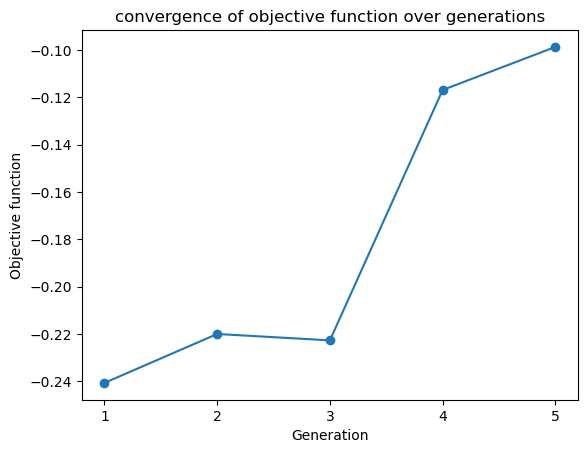

In [84]:
# Plot the best fitnesses over generations
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

y_values, x_values = zip(*bests)
#y_values = [y  for y in y_values]
# Creating the plot
plt.plot(x_values, y_values, marker='o')

# Adding titles and labels
plt.title('convergence of objective function over generations')
plt.xlabel('Generation')
plt.ylabel('Objective function')

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

# Showing the plot
plt.show()

In [66]:
best_index = population_fitness_our(population).index(max(population_fitness_our(population)))
print(len(population))
print(population[best_index])

100
[3, 3, 7, 7, 18, 18, 3, 3, 3, 3, 3, 15, 11, 13, 11, 18, 18, 18, 2, 9, 9, 15, 15, 15, 3, 3, 3, 15, 3, 6, 6, 6, 15, 15, 15, 11, 20, 11, 2, 2, 9, 2, 2, 2, 15, 24, 24, 24, 24, 24, 24, 24, 24, 24, 3, 24, 8, 24, 23, 23, 23, 24, 24, 23, 23, 2, 2, 21, 21, 2, 2, 2, 2, 11, 12, 12, 12, 8, 8, 8, 20, 20, 20, 20, 5, 17, 17, 20, 15, 8, 8, 8, 9, 19, 19, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 4, 4, 5, 4, 4, 1, 1, 1, 19, 19, 2, 2, 2, 5, 5, 19, 19, 11, 11, 14, 18, 14, 10, 10, 14, 14, 14, 14, 14, 8, 8, 20, 22, 22, 22, 22, 21, 15, 15, 1, 18, 18, 18, 8, 8, 8, 8, 20, 9, 9, 7, 7, 21, 21, 16, 16, 20, 7, 5, 21, 5, 4, 5, 18, 5, 10, 24, 21, 4, 6, 23, 4, 14, 4, 4, 4, 4, 12, 4, 4, 4, 8, 4, 4, 19, 4, 10, 4, 4, 5, 14, 14, 5, 13, 7, 5, 5, 16, 5, 5, 5, 5, 19, 5, 23, 5, 10, 5, 20, 10, 5, 5, 5, 6, 25, 5, 5, 16, 18, 5, 5, 11, 23, 5, 18, 5, 5, 5, 5, 19, 7, 7, 22, 22, 22, 14, 14, 21, 21, 21, 10, 10, 10, 17, 10, 16, 16, 19, 19, 5, 3, 18, 16, 16, 16, 16, 16, 12, 12, 12, 12, 12, 12, 12, 12, 12, 15, 12, 22, 22, 17, 17, 17, 10, 10, 7

In [80]:
def predicted_complexes(clusters):
    c = []
    for cluster in clusters:
        if len(cluster)>1 :
            for i in range(len(cluster)):
                    cluster[i] = dfID['Protein'][cluster[i]-1].strip("'")
            c.append((cluster))
            #print(cluster)
    return c

In [82]:
print(fitness_function_o(AdjMat, population[best_index])[0])
clusters = decode_o(population[best_index])
print(len(clusters))
pred_complexes=predicted_complexes(clusters)
#print(pred_complexes)


0.27245050383776276
25
[['bmi1a', 'cbx4', 'phc2a', 'rnf2', 'bmi1b', 'CUL3', 'btbd6a', 'zbtb16a', 'keap1a', 'lmna', 'fam169ab', 'nup210', 'slu7', 'zgc:171223', 'tprb', 'dnttip2', 'ik', 'cmtr1', 'lrrc59', 'si:dkeyp-82a1.6', 'dbn1', 'znf618', 'nup155', 'rnaseh2b', 'bop1', 'syne1a', 'rbfox1l', 'snrpc', 'vapb', 'nifk', 'nhp2', 'aatf', 'bet1', 'arhgef39', 'egln1b', 'kif20a', 'wdr3', 'zc3h4', 'col11a1a', 'avd', 'acss2', 'fam192a', 'ebf3a', 'rab8a', 'yod1'], ['ndr2', 'bmp4', 'wnt8a', 'vox', 'vent', 'bmp2b', 'wnt3a', 'sp5l', 'ved', 'lhx5', 'sfrp1a', 'sfrp5', 'smarca4a', 'tbx5a', 'setd8a', 'zgc:152977', 'syne2a', 'stim1a', 'vapa', 'zgc:77056', 'smarcd3a', 'arf3b', 'frem2b', 'ank3b', 'aaas', 'sae1'], ['stub1', 'ube2d1b', 'apc', 'axin1', 'mstnb', 'cdkn1a', 'prickle1a', 'fgf3', 'hnf1ba', 'wnt8b', 'fzd8a', 'Smad6', 'runx2b', 'Vdr', 'VDR', 'vdra', 'Runx2', 'aldh1l1', 'vrk3', 'mad1l1', 'ddx46', 'rnmt', 'rbm5', 'tead3b', 'ctdspl2a', 'znf281b', 'zgc:153426', 'kpna4', 'crygm2f'], ['mib2', 'ubb', 'dla', '

'for i in range(len(population)):\n    clusters = decode_o(population[i])\n    print(len(clusters))'

In [22]:
df=pd.read_csv('G:\Study\Master\PFE\DATA\collinsID.csv')
df

,ID,LocuslinkID,Name
0,0,855173,YMR142C
1,1,855174,YMR143W
2,2,855170,YMR139W
3,3,855549,YNL172W
4,4,856208,YPR093C
...,...,...,...
1615,1615,853498,YJR041C
1616,1616,853499,YJR042W
1617,1617,851212,YAL021C
1618,1618,855208,YMR172W


### Protein complexes banchmark (Saccharomyces cerevisiae)

In [23]:
# CYC2008 database contains 408 complexes with 1920 protein
complexes_CYC2008 = []
with open('G:\Study\Master\PFE\DATA\CYC2008_complexes.txt', 'r') as file:
    # Process the lines
    for line in file:
        # Split the line into elements based on a delimiter (e.g., space)
        elements = line.strip().split()  # Use strip() to remove trailing whitespace
                                          # Use split() to split the line into elements
            
        # Append the list of elements to the lines_list
        complexes_CYC2008.append(elements)
    #print(complexes_CYC2008)
    
# MIPS database contains 203 complexes with 2541 protein
complexes_MIPS = []
with open('G:\Study\Master\PFE\DATA\Software and Datasets\Datasets\Reference Set_MIPS.txt', 'r') as file:
    
    for line in file:
        elements = line.strip().split()  
        del elements[0]
        
        complexes_MIPS.append(elements)
        
    #print(complexes_MIPS)

# SGD database contains 323 complexes with 1758 protein
complexes_SGD = []
with open('G:\Study\Master\PFE\DATA\SGD_complexes.txt', 'r') as file:
    
    for line in file:
        elements = line.strip().split()  
        
        complexes_SGD.append(elements)
    #print(complexes_SGD)
    
from pathlib import Path
import xml.etree.ElementTree as ET
import pandas as pd

# Parse XML file

ns = {'ns': 'http://psi.hupo.org/mi/mif'}

# Specify the directory path
directory = Path('G:\Study\Master\PFE\DATA\Saccharomyces_cerevisiae')

# Iterate over all files in the directory
complexes_CP = []
for filepath in directory.iterdir():
    # Check if the path is a file (not a directory)
    complexe = []
    if filepath.is_file():
        tree = ET.parse(filepath)
        root = tree.getroot()
        for interactors in root[0][2].findall('.//ns:interactor',ns):
            names = interactors.find('.//ns:names', ns)
            if names is not None:
                for alias in names.findall('.//ns:alias', ns):
                    if alias.attrib['type'] == "locus name":
                        complexe.append(alias.text)
    #print(complexe)
    complexes_CP.append(complexe)

In [24]:
best_solution_400 = [131, 289, 225, 157, 267, 326, 31, 243, 384, 336, 85, 24, 255, 76, 392, 234, 390, 264, 105, 144, 206, 352, 91, 189, 101, 125, 45, 214, 314, 308, 212, 384, 343, 326, 242, 397, 361, 223, 69, 401, 252, 392, 128, 344, 254, 339, 36, 362, 393, 63, 106, 147, 276, 15, 57, 203, 119, 325, 136, 296, 349, 164, 76, 82, 3, 108, 18, 289, 5, 43, 348, 86, 177, 336, 171, 398, 150, 289, 239, 31, 358, 57, 13, 155, 227, 206, 249, 113, 73, 234, 335, 274, 1, 377, 375, 167, 3, 8, 235, 400, 382, 65, 380, 148, 166, 191, 134, 353, 385, 168, 101, 110, 372, 280, 305, 108, 62, 127, 227, 43, 64, 109, 296, 381, 215, 73, 178, 101, 102, 14, 140, 207, 302, 224, 228, 343, 125, 129, 63, 146, 220, 121, 70, 134, 311, 108, 295, 358, 386, 244, 127, 184, 179, 238, 88, 39, 382, 116, 267, 381, 56, 65, 91, 212, 97, 68, 108, 268, 149, 242, 78, 47, 292, 131, 69, 352, 281, 108, 212, 173, 127, 256, 40, 344, 161, 319, 31, 387, 355, 392, 277, 276, 375, 31, 400, 215, 292, 280, 221, 328, 355, 25, 200, 74, 172, 292, 257, 215, 46, 109, 33, 46, 88, 278, 36, 27, 205, 377, 276, 377, 57, 236, 386, 372, 315, 219, 236, 216, 132, 289, 270, 334, 272, 35, 364, 334, 60, 368, 355, 10, 17, 3, 312, 38, 301, 4, 152, 124, 273, 204, 399, 381, 368, 123, 61, 151, 149, 260, 87, 266, 137, 174, 41, 321, 324, 116, 325, 57, 304, 339, 293, 390, 108, 374, 327, 349, 271, 169, 332, 356, 52, 388, 100, 35, 321, 168, 123, 369, 318, 226, 35, 274, 24, 144, 47, 26, 67, 84, 57, 391, 67, 310, 186, 258, 77, 97, 43, 130, 364, 360, 36, 161, 165, 177, 293, 263, 33, 231, 123, 393, 156, 76, 308, 295, 149, 46, 46, 232, 167, 255, 295, 84, 350, 200, 185, 15, 312, 282, 86, 342, 285, 196, 87, 392, 357, 252, 337, 339, 164, 33, 27, 2, 175, 137, 150, 129, 290, 59, 148, 98, 238, 154, 145, 253, 337, 5, 303, 252, 283, 62, 124, 204, 165, 314, 274, 316, 166, 238, 222, 115, 266, 229, 189, 398, 41, 153, 113, 378, 279, 329, 390, 232, 331, 308, 389, 170, 13, 171, 227, 234, 217, 382, 246, 256, 113, 14, 254, 239, 156, 39, 327, 111, 158, 159, 188, 72, 51, 84, 169, 117, 110, 310, 313, 111, 84, 304, 90, 62, 1, 33, 292, 28, 127, 112, 299, 384, 364, 235, 138, 6, 303, 185, 231, 246, 83, 268, 336, 108, 70, 225, 144, 139, 96, 191, 8, 107, 130, 154, 9, 101, 315, 5, 276, 213, 286, 192, 181, 83, 28, 312, 23, 295, 314, 188, 188, 244, 213, 8, 313, 130, 243, 376, 183, 313, 262, 304, 138, 180, 15, 290, 213, 393, 269, 9, 127, 207, 207, 388, 279, 352, 221, 223, 303, 264, 319, 261, 275, 277, 238, 296, 98, 268, 212, 27, 60, 44, 388, 145, 45, 283, 149, 180, 353, 288, 16, 161, 292, 14, 389, 329, 75, 170, 213, 367, 198, 245, 332, 341, 240, 241, 207, 310, 378, 83, 252, 348, 165, 298, 178, 91, 350, 341, 299, 378, 285, 58, 110, 329, 92, 401, 297, 277, 253, 303, 161, 143, 117, 61, 76, 355, 190, 389, 92, 146, 224, 80, 201, 312, 264, 115, 232, 377, 143, 165, 29, 366, 264, 132, 265, 138, 365, 57, 85, 359, 378, 62, 222, 57, 92, 169, 326, 33, 210, 132, 158, 276, 344, 94, 263, 100, 73, 55, 80, 234, 77, 363, 165, 222, 78, 47, 20, 185, 173, 111, 32, 28, 134, 223, 56, 221, 252, 294, 8, 143, 31, 372, 313, 116, 320, 376, 59, 203, 317, 249, 240, 357, 27, 215, 94, 26, 198, 209, 43, 310, 77, 1, 225, 306, 237, 339, 83, 35, 111, 34, 327, 382, 170, 71, 133, 87, 48, 169, 222, 290, 310, 392, 86, 349, 164, 95, 323, 73, 62, 129, 19, 351, 193, 92, 223, 291, 141, 151, 384, 161, 205, 154, 349, 147, 236, 100, 305, 182, 50, 389, 364, 218, 332, 353, 384, 329, 48, 270, 231, 228, 358, 88, 213, 209, 389, 341, 62, 61, 288, 350, 266, 30, 39, 235, 349, 399, 360, 135, 16, 62, 352, 327, 364, 292, 268, 322, 212, 165, 41, 62, 211, 163, 151, 72, 378, 109, 56, 368, 387, 251, 206, 280, 201, 326, 209, 89, 380, 300, 108, 307, 65, 381, 214, 81, 302, 324, 178, 285, 16, 76, 369, 64, 82, 235, 82, 354, 98, 287, 326, 5, 158, 387, 391, 93, 45, 185, 85, 368, 334, 192, 177, 185, 158, 200, 365, 1, 296, 168, 394, 266, 321, 95, 82, 96, 361, 82, 183, 29, 108, 214, 239, 13, 342, 42, 206, 175, 360, 357, 349, 312, 178, 46, 341, 14, 98, 114, 292, 275, 36, 63, 235, 106, 315, 83, 92, 110, 236, 348, 272, 165, 239, 117, 253, 69, 328, 2, 205, 226, 277, 377, 42, 354, 107, 334, 47, 259, 242, 329, 350, 87, 311, 56, 150, 328, 326, 144, 41, 344, 80, 101, 193, 75, 79, 328, 142, 61, 275, 305, 388, 402, 269, 60, 226, 272, 267, 185, 235, 132, 171, 326, 188, 180, 64, 31, 152, 8, 266, 297, 118, 263, 330, 83, 149, 288, 108, 62, 31, 300, 43, 193, 26, 62, 47, 25, 35, 403, 180, 122, 325, 269, 230, 400, 212, 244, 228, 100, 327, 402, 46, 171, 34, 103, 203, 325, 10, 238, 285, 283, 363, 255, 149, 138, 390, 26, 162, 306, 329, 176, 19, 100, 247, 89, 257, 294, 159, 349, 308, 48, 11, 194, 338, 4, 360, 233, 281, 155, 343, 12, 68, 249, 49, 133, 183, 357, 6, 155, 373, 220, 33, 82, 77, 281, 268, 279, 87, 394, 144, 392, 363, 150, 365, 35, 187, 241, 377, 116, 286, 368, 74, 353, 205, 229, 375, 79, 305, 162, 394, 27, 212, 77, 222, 42, 355, 243, 237, 57, 12, 231, 176, 198, 91, 174, 259, 257, 270, 35, 135, 382, 224, 208, 82, 249, 28, 309, 270, 400, 320, 33, 263, 264, 10, 331, 357, 195, 378, 222, 303, 110, 206, 206, 151, 180, 352, 349, 350, 69, 394, 219, 61, 170, 268, 357, 357, 45, 63, 400, 172, 392, 151, 305, 71, 271, 82, 25, 378, 218, 281, 28, 114, 285, 351, 190, 114, 290, 104, 145, 288, 31, 25, 355, 374, 155, 105, 312, 391, 38, 179, 339, 349, 61, 335, 194, 210, 149, 280, 374, 115, 178, 131, 184, 90, 375, 208, 364, 253, 359, 202, 201, 157, 209, 321, 305, 246, 278, 172, 25, 130, 348, 174, 384, 345, 396, 375, 337, 357, 22, 343, 150, 188, 253, 149, 265, 135, 182, 43, 348, 365, 154, 348, 307, 235, 361, 33, 261, 78, 215, 119, 264, 57, 181, 337, 13, 321, 120, 380, 364, 10, 159, 41, 313, 126, 278, 185, 160, 185, 144, 154, 300, 372, 371, 16, 35, 197, 120, 204, 179, 277, 365, 276, 180, 330, 349, 134, 363, 103, 130, 289, 374, 236, 357, 282, 337, 123, 314, 223, 67, 221, 64, 349, 77, 42, 276, 39, 373, 62, 374, 299, 27, 17, 292, 9, 209, 235, 255, 73, 112, 305, 27, 287, 84, 373, 103, 336, 190, 286, 97, 156, 220, 136, 225, 158, 50, 98, 140, 191, 310, 116, 329, 143, 335, 344, 358, 371, 287, 327, 240, 57, 277, 64, 333, 383, 62, 49, 103, 75, 251, 187, 46, 100, 132, 384, 178, 186, 164, 159, 139, 117, 39, 287, 50, 53, 265, 330, 303, 377, 376, 363, 73, 56, 214, 18, 59, 363, 370, 113, 197, 198, 59, 36, 360, 91, 237, 56, 6, 46, 236, 212, 156, 182, 131, 46, 222, 72, 306, 91, 336, 99, 193, 54, 263, 87, 333, 267, 57, 94, 369, 48, 116, 222, 190, 68, 62, 317, 174, 324, 84, 251, 371, 270, 292, 302, 193, 376, 206, 19, 243, 35, 215, 234, 75, 73, 339, 341, 241, 188, 299, 181, 137, 44, 123, 267, 222, 62, 221, 358, 46, 282, 282, 321, 363, 240, 48, 190, 286, 215, 33, 353, 108, 172, 92, 109, 62, 130, 359, 108, 276, 112, 101, 110, 97, 329, 141, 274, 299, 42, 121, 149, 26, 300, 127, 313, 386, 399, 317, 8, 62, 337, 203, 256, 156, 350, 235, 82, 271, 384, 161, 199, 215, 97, 98, 244, 309, 335, 31, 255, 12, 392, 43, 378, 283, 57, 9, 240, 322, 31, 342, 63, 49, 246, 63, 207, 136, 167, 31, 221, 318, 178, 228, 291, 363, 93, 106, 92, 102, 175, 88, 164, 292, 95, 249, 291, 129, 160, 252, 18, 95, 298, 230, 223, 318, 387, 236, 3, 74, 394, 232, 221, 215, 343, 246, 327, 150, 256, 395, 353, 243, 112, 127, 199, 6, 74, 66, 301, 265, 35, 62, 398, 247, 234, 63, 49, 305, 45, 259, 398, 165, 183, 54, 119, 7, 327, 331, 300, 68, 311, 184, 48, 97, 285, 303, 203, 15, 204, 231, 215, 53, 16, 75, 1, 250, 28, 13, 276, 181, 36, 10, 395, 149, 76, 319, 312, 66, 122, 82, 25, 285, 375, 146, 87, 100, 343, 292, 199, 73, 322, 76, 43, 51, 220, 97, 31, 222, 358, 226, 68, 118, 148, 62, 45, 156, 165, 23, 185, 15, 274, 367, 259, 331, 19, 2, 5, 63, 330, 194, 193, 127, 180, 342, 364, 388, 147, 175, 57, 119, 352, 170, 3, 30, 214, 252, 85, 251, 312, 245, 347, 5, 262, 338, 276, 15, 42, 212, 134, 155, 24, 371]
best_solution_260 = [116, 33, 76, 61, 168, 107, 259, 210, 228, 169, 153, 107, 6, 152, 236, 146, 57, 168, 254, 94, 140, 109, 204, 151, 174, 147, 64, 188, 200, 234, 212, 261, 53, 231, 18, 29, 40, 242, 251, 214, 220, 133, 64, 248, 116, 125, 127, 181, 159, 220, 21, 256, 224, 171, 215, 213, 248, 169, 61, 79, 258, 72, 144, 265, 206, 105, 204, 34, 29, 210, 162, 265, 108, 18, 29, 3, 247, 4, 48, 29, 75, 31, 96, 114, 221, 261, 262, 168, 150, 185, 173, 131, 143, 29, 156, 132, 67, 26, 147, 203, 18, 209, 121, 60, 262, 217, 94, 169, 86, 128, 261, 139, 194, 232, 48, 161, 41, 213, 15, 43, 197, 202, 155, 109, 185, 249, 36, 33, 260, 137, 207, 49, 236, 251, 159, 124, 50, 264, 20, 237, 210, 29, 203, 24, 29, 161, 39, 26, 57, 12, 238, 172, 27, 229, 263, 146, 253, 165, 197, 99, 224, 166, 138, 124, 241, 254, 79, 124, 55, 117, 214, 194, 117, 44, 58, 86, 172, 105, 208, 237, 4, 184, 22, 71, 139, 41, 20, 48, 137, 61, 152, 110, 167, 217, 217, 194, 241, 224, 106, 72, 223, 185, 247, 21, 28, 41, 173, 104, 261, 94, 242, 24, 192, 96, 1, 213, 174, 136, 159, 239, 210, 239, 162, 146, 3, 207, 256, 197, 29, 226, 14, 209, 1, 33, 87, 213, 159, 87, 96, 65, 93, 217, 49, 243, 176, 69, 83, 119, 23, 212, 185, 90, 154, 34, 66, 77, 134, 86, 39, 263, 264, 244, 254, 163, 233, 245, 48, 198, 126, 87, 195, 49, 161, 74, 193, 17, 114, 61, 237, 61, 143, 185, 111, 200, 258, 52, 55, 223, 221, 22, 46, 87, 92, 92, 223, 92, 263, 170, 44, 213, 72, 213, 193, 190, 187, 134, 86, 172, 167, 29, 181, 17, 78, 129, 113, 165, 219, 80, 83, 126, 149, 241, 131, 123, 55, 28, 258, 238, 262, 209, 105, 86, 223, 120, 209, 135, 160, 136, 52, 190, 1, 146, 256, 61, 49, 150, 14, 240, 91, 57, 87, 59, 29, 110, 112, 18, 29, 257, 8, 25, 261, 181, 55, 82, 261, 130, 84, 107, 163, 147, 26, 1, 162, 103, 56, 176, 254, 54, 245, 78, 26, 265, 181, 185, 17, 140, 157, 126, 180, 224, 106, 126, 103, 192, 45, 130, 12, 55, 92, 34, 8, 11, 263, 200, 138, 153, 27, 56, 27, 94, 259, 18, 180, 180, 139, 86, 115, 153, 148, 93, 129, 246, 31, 36, 182, 205, 151, 67, 57, 177, 72, 59, 9, 176, 78, 203, 189, 117, 263, 146, 91, 216, 50, 152, 202, 233, 29, 193, 38, 151, 257, 186, 237, 230, 7, 198, 236, 54, 173, 139, 76, 165, 138, 109, 113, 178, 154, 176, 258, 23, 191, 166, 243, 121, 153, 244, 67, 74, 31, 76, 88, 87, 201, 160, 210, 62, 221, 175, 69, 28, 228, 26, 24, 238, 193, 159, 29, 263, 82, 251, 229, 136, 192, 155, 29, 9, 121, 78, 108, 31, 257, 183, 208, 225, 24, 114, 56, 25, 115, 29, 214, 151, 255, 134, 238, 24, 252, 202, 45, 189, 32, 248, 226, 207, 235, 149, 123, 129, 262, 67, 200, 248, 146, 158, 218, 263, 236, 5, 225, 254, 92, 82, 120, 64, 167, 107, 142, 162, 227, 209, 69, 121, 82, 238, 26, 156, 11, 126, 223, 91, 46, 51, 172, 244, 12, 167, 237, 26, 245, 142, 182, 35, 64, 203, 222, 263, 176, 135, 75, 7, 158, 65, 265, 167, 175, 29, 252, 58, 93, 153, 107, 177, 52, 135, 126, 96, 259, 27, 183, 203, 176, 75, 167, 24, 248, 143, 67, 21, 214, 129, 117, 59, 237, 53, 254, 124, 131, 198, 105, 106, 74, 132, 169, 28, 106, 73, 31, 89, 65, 85, 51, 30, 252, 31, 46, 131, 246, 75, 120, 146, 235, 234, 26, 174, 125, 242, 77, 87, 178, 207, 195, 264, 87, 150, 103, 34, 242, 175, 56, 155, 257, 6, 106, 41, 213, 133, 241, 196, 226, 199, 202, 35, 241, 141, 80, 87, 49, 210, 67, 44, 26, 168, 261, 188, 25, 207, 8, 93, 137, 128, 39, 90, 254, 51, 157, 141, 235, 238, 229, 70, 238, 30, 42, 175, 66, 236, 77, 197, 199, 262, 241, 98, 192, 250, 226, 169, 122, 241, 6, 58, 197, 119, 197, 252, 198, 197, 34, 252, 60, 205, 259, 79, 1, 252, 213, 254, 56, 265, 155, 90, 170, 181, 88, 32, 170, 17, 237, 262, 173, 185, 206, 73, 161, 132, 166, 73, 53, 141, 48, 68, 45, 260, 165, 150, 125, 87, 191, 152, 202, 183, 209, 244, 193, 179, 140, 78, 29, 153, 187, 87, 138, 107, 25, 76, 257, 213, 222, 182, 96, 194, 101, 129, 69, 106, 94, 162, 202, 232, 96, 202, 25, 175, 193, 173, 203, 4, 158, 17, 151, 259, 233, 144, 25, 205, 186, 24, 64, 15, 241, 71, 241, 256, 68, 258, 48, 89, 80, 194, 122, 139, 141, 125, 36, 262, 167, 37, 42, 213, 265, 115, 19, 259, 135, 203, 172, 173, 56, 32, 258, 217, 102, 165, 151, 150, 55, 193, 76, 155, 35, 231, 168, 218, 130, 12, 29, 186, 125, 125, 83, 47, 256, 134, 97, 36, 51, 5, 134, 208, 255, 1, 252, 213, 76, 71, 227, 155, 236, 172, 262, 152, 92, 229, 130, 151, 132, 182, 247, 86, 105, 117, 87, 258, 133, 29, 109, 29, 183, 84, 208, 48, 12, 66, 31, 12, 122, 119, 208, 146, 137, 181, 77, 53, 197, 170, 64, 56, 199, 158, 136, 92, 209, 173, 144, 175, 247, 221, 40, 66, 132, 204, 228, 255, 44, 25, 199, 258, 105, 20, 237, 100, 61, 240, 121, 229, 239, 69, 29, 123, 236, 148, 168, 205, 87, 7, 31, 140, 59, 71, 241, 219, 173, 149, 188, 202, 125, 66, 246, 207, 134, 146, 160, 236, 55, 232, 213, 182, 83, 206, 199, 71, 113, 97, 168, 106, 14, 87, 197, 25, 48, 189, 61, 176, 14, 255, 8, 122, 159, 129, 43, 81, 111, 131, 201, 132, 141, 221, 138, 104, 49, 141, 114, 6, 18, 35, 191, 119, 202, 177, 51, 129, 260, 177, 98, 21, 65, 175, 23, 254, 25, 147, 91, 139, 25, 195, 216, 1, 109, 75, 82, 52, 30, 42, 152, 109, 183, 149, 162, 46, 152, 163, 254, 61, 208, 196, 72, 66, 202, 150, 158, 79, 71, 257, 12, 190, 229, 139, 71, 3, 57, 6, 14, 114, 120, 173, 239, 85, 254, 226, 198, 127, 205, 203, 7, 10, 24, 140, 215, 214, 197, 247, 207, 8, 80, 262, 211, 187, 35, 120, 209, 138, 180, 158, 219, 71, 46, 147, 83, 83, 105, 151, 248, 216, 154, 70, 140, 110, 171, 212, 18, 232, 15, 42, 148, 92, 79, 212, 250, 151, 137, 57, 19, 213, 148, 46, 48, 128, 82, 164, 227, 185, 3, 263, 150, 209, 136, 18, 204, 93, 206, 208, 246, 133, 161, 31, 205, 95, 216, 185, 216, 90, 54, 182, 49, 4, 238, 264, 26, 28, 117, 81, 196, 138, 252, 97, 42, 161, 71, 198, 228, 17, 183, 77, 52, 202, 248, 178, 175, 8, 221, 59, 224, 80, 74, 125, 214, 104, 212, 161, 147, 132, 247, 77, 244, 6, 16, 126, 241, 175, 213, 83, 184, 194, 36, 34, 110, 115, 89, 107, 172, 20, 7, 165, 156, 92, 192, 158, 224, 1, 128, 194, 262, 205, 40, 47, 191, 123, 187, 252, 218, 10, 75, 113, 37, 182, 106, 147, 192, 188, 161, 68, 100, 37, 231, 145, 161, 130, 48, 241, 199, 96, 138, 146, 259, 225, 32, 29, 68, 161, 258, 33, 55, 139, 191, 33, 67, 104, 199, 152, 48, 59, 47, 159, 28, 53, 248, 76, 96, 141, 24, 147, 193, 27, 110, 58, 28, 23, 173, 52, 53, 198, 242, 182, 20, 255, 205, 144, 23, 53, 138, 255, 44, 241, 233, 127, 172, 184, 67, 177, 185, 90, 150, 136, 12, 41, 169, 12, 181, 118, 63, 166, 208, 125, 2, 121, 91, 220, 225, 206, 23, 4, 242, 64, 114, 112, 82, 76, 184, 159, 124, 28, 162, 105, 138, 144, 246, 257, 21, 67, 12, 113, 130, 161, 97, 102, 167, 147, 204, 255, 161, 129, 24, 158, 259, 103, 205, 91, 198, 165, 163, 104, 124, 209, 110, 142, 238, 167, 20, 251, 151, 117, 201, 56, 29, 135, 151, 41, 265, 169, 24, 233, 181, 257, 202, 2, 71, 126, 69, 207, 103, 111, 236, 203, 112, 234, 122, 251, 5, 155, 231, 158, 177, 179, 59, 20, 9, 100, 259, 225, 140, 78, 34, 59, 132, 55, 95, 30, 29, 62, 37, 180, 19, 41, 162, 160, 72, 139, 137, 106, 68, 162, 256, 15, 154, 222, 112, 203, 188, 79, 253, 29, 203, 254, 52, 213, 256, 101, 182, 15, 25, 226, 86, 189, 148, 130, 265, 58, 116, 132, 244, 48, 50, 122, 193, 219, 100, 137, 4, 104, 212, 110, 62, 203, 129, 140, 25, 175, 69, 152, 220, 261, 233, 48, 11, 264, 167, 127, 163, 244, 109, 89, 165, 68, 88, 191, 93, 40, 104, 131, 55, 207, 92, 233, 247, 262, 29, 125, 151, 265, 151, 119, 21, 191, 57, 202, 136, 241, 111, 262, 135, 146, 105, 222, 224, 163, 163, 228, 199, 201, 225, 124, 149, 147, 199, 184, 40, 126, 208, 122, 180, 225, 126, 175, 63, 115, 26, 219, 144, 212, 26, 14, 138, 39, 136, 154, 256, 241, 8, 221, 145, 199, 77, 222, 30, 255, 217, 148, 104, 236, 34, 16, 210, 233, 261, 127, 102, 27, 60, 18, 38, 244]
best_solution_75 = [49, 68, 29, 41, 46, 64, 37, 29, 61, 66, 66, 26, 1, 63, 26, 26, 76, 15, 73, 1, 72, 20, 23, 57, 3, 22, 27, 33, 69, 62, 4, 71, 25, 54, 49, 21, 75, 67, 14, 18, 11, 26, 41, 10, 10, 63, 45, 14, 55, 63, 10, 6, 5, 77, 27, 76, 8, 16, 9, 54, 23, 24, 10, 16, 68, 71, 36, 45, 4, 37, 75, 67, 54, 55, 21, 23, 60, 25, 22, 62, 64, 77, 66, 70, 2, 30, 49, 17, 18, 48, 53, 18, 48, 21, 69, 23, 52, 4, 22, 25, 28, 68, 33, 20, 36, 57, 54, 16, 36, 68, 31, 42, 18, 71, 22, 46, 22, 42, 31, 1, 44, 16, 34, 35, 46, 58, 50, 58, 65, 25, 39, 21, 52, 43, 53, 11, 40, 40, 76, 17, 48, 22, 7, 64, 62, 46, 55, 52, 50, 26, 17, 77, 37, 1, 45, 31, 60, 30, 74, 50, 45, 12, 9, 57, 24, 64, 46, 6, 33, 11, 23, 42, 22, 50, 14, 40, 50, 46, 10, 37, 76, 71, 53, 50, 59, 24, 13, 22, 54, 70, 13, 47, 62, 76, 71, 11, 22, 5, 72, 6, 74, 36, 42, 19, 56, 24, 58, 31, 71, 16, 13, 56, 6, 35, 49, 32, 27, 44, 66, 44, 29, 56, 15, 26, 18, 16, 56, 14, 22, 7, 4, 8, 42, 38, 57, 14, 65, 10, 48, 31, 63, 1, 39, 34, 74, 3, 45, 48, 23, 42, 42, 62, 38, 34, 66, 47, 1, 71, 63, 62, 67, 72, 73, 48, 25, 68, 53, 50, 29, 70, 15, 73, 46, 54, 51, 4, 48, 21, 48, 44, 32, 44, 9, 18, 58, 52, 27, 75, 15, 21, 68, 70, 15, 49, 55, 19, 1, 53, 12, 37, 72, 32, 34, 38, 17, 50, 34, 34, 30, 77, 59, 4, 59, 16, 47, 53, 13, 42, 73, 35, 25, 72, 40, 3, 33, 56, 56, 42, 67, 44, 46, 73, 12, 67, 20, 33, 45, 28, 44, 38, 65, 34, 29, 26, 30, 40, 3, 36, 62, 76, 7, 9, 22, 3, 38, 10, 21, 29, 68, 18, 32, 31, 51, 3, 65, 60, 21, 26, 64, 22, 27, 28, 4, 1, 30, 3, 7, 4, 64, 77, 25, 46, 14, 42, 4, 72, 43, 28, 30, 39, 72, 68, 1, 51, 17, 21, 26, 2, 19, 41, 28, 8, 11, 21, 71, 2, 55, 28, 40, 54, 46, 55, 69, 30, 67, 34, 19, 27, 55, 25, 58, 71, 65, 14, 13, 63, 57, 24, 26, 13, 22, 19, 45, 38, 4, 15, 68, 22, 73, 26, 80, 10, 60, 77, 11, 11, 22, 46, 24, 74, 35, 35, 48, 50, 76, 69, 43, 2, 41, 27, 50, 26, 74, 20, 35, 44, 48, 38, 14, 51, 75, 2, 74, 71, 60, 2, 35, 7, 65, 39, 73, 1, 51, 2, 55, 60, 75, 48, 14, 54, 48, 27, 56, 60, 74, 37, 21, 75, 47, 25, 2, 36, 20, 66, 22, 1, 14, 54, 36, 28, 58, 11, 10, 23, 10, 65, 21, 51, 71, 21, 25, 57, 11, 34, 57, 56, 22, 16, 12, 68, 39, 29, 67, 32, 1, 30, 69, 58, 45, 8, 63, 24, 26, 9, 11, 73, 26, 23, 50, 10, 39, 9, 22, 24, 22, 26, 10, 43, 46, 75, 21, 61, 7, 13, 45, 69, 52, 21, 47, 75, 76, 8, 69, 81, 11, 63, 8, 26, 68, 3, 68, 48, 66, 30, 17, 27, 28, 47, 75, 4, 38, 74, 61, 44, 61, 22, 24, 61, 57, 68, 26, 63, 10, 10, 66, 69, 63, 40, 75, 15, 28, 75, 22, 71, 17, 2, 15, 67, 23, 58, 22, 25, 37, 71, 73, 1, 30, 46, 46, 44, 57, 19, 41, 42, 64, 13, 77, 62, 31, 14, 55, 53, 24, 77, 67, 8, 45, 21, 65, 77, 1, 48, 46, 32, 17, 50, 19, 47, 49, 76, 44, 10, 23, 11, 3, 20, 42, 39, 12, 64, 52, 49, 64, 22, 32, 26, 72, 42, 67, 33, 16, 54, 22, 5, 27, 75, 73, 42, 14, 39, 27, 11, 71, 26, 73, 47, 17, 64, 20, 62, 55, 6, 35, 27, 75, 36, 10, 69, 34, 77, 2, 15, 9, 5, 35, 26, 13, 18, 43, 34, 24, 73, 42, 48, 50, 45, 6, 24, 29, 7, 56, 48, 19, 22, 8, 75, 70, 22, 20, 53, 10, 62, 2, 24, 11, 73, 57, 42, 25, 1, 72, 14, 25, 33, 54, 23, 8, 39, 9, 51, 53, 82, 71, 35, 12, 65, 1, 52, 22, 42, 47, 65, 71, 53, 17, 59, 39, 13, 16, 75, 1, 37, 54, 48, 64, 61, 21, 71, 17, 59, 28, 26, 62, 7, 35, 59, 4, 71, 45, 36, 5, 63, 1, 72, 67, 43, 16, 69, 66, 16, 7, 10, 46, 45, 69, 21, 36, 3, 74, 22, 14, 2, 37, 49, 1, 56, 3, 61, 26, 54, 22, 7, 22, 76, 22, 67, 17, 38, 57, 29, 57, 69, 57, 5, 24, 71, 24, 49, 41, 30, 28, 41, 5, 15, 69, 45, 20, 50, 58, 56, 1, 7, 57, 43, 48, 71, 11, 25, 26, 26, 33, 37, 54, 9, 22, 55, 30, 69, 45, 15, 7, 50, 7, 67, 55, 23, 41, 5, 17, 65, 24, 12, 60, 54, 67, 25, 26, 6, 10, 76, 12, 72, 32, 36, 42, 69, 33, 51, 46, 22, 68, 28, 26, 21, 48, 22, 51, 2, 23, 22, 33, 28, 77, 4, 35, 77, 10, 59, 15, 14, 6, 57, 56, 19, 29, 9, 51, 9, 70, 69, 65, 51, 40, 1, 33, 70, 57, 13, 12, 41, 60, 17, 27, 33, 3, 3, 46, 76, 60, 10, 40, 30, 13, 72, 44, 3, 50, 51, 47, 23, 29, 38, 10, 2, 21, 64, 67, 54, 71, 76, 23, 30, 2, 16, 17, 33, 71, 16, 37, 26, 2, 49, 51, 59, 36, 19, 73, 2, 40, 27, 6, 2, 65, 48, 28, 59, 47, 4, 22, 9, 11, 28, 10, 17, 31, 6, 29, 40, 1, 52, 18, 71, 29, 57, 52, 11, 19, 34, 33, 36, 37, 42, 55, 63, 16, 77, 16, 76, 7, 62, 40, 76, 28, 69, 31, 1, 38, 73, 67, 22, 9, 29, 5, 72, 10, 28, 69, 30, 46, 52, 8, 9, 76, 73, 11, 43, 1, 63, 76, 38, 75, 26, 11, 58, 5, 76, 16, 1, 67, 27, 54, 48, 54, 64, 64, 42, 54, 38, 76, 75, 23, 65, 40, 1, 8, 74, 73, 73, 48, 12, 19, 1, 9, 41, 56, 72, 54, 25, 30, 15, 60, 38, 47, 35, 21, 17, 5, 57, 19, 19, 18, 37, 61, 32, 39, 53, 35, 19, 71, 14, 5, 69, 62, 54, 44, 2, 74, 76, 50, 50, 3, 6, 45, 13, 33, 10, 48, 74, 55, 69, 19, 11, 63, 11, 22, 53, 12, 44, 32, 14, 52, 55, 13, 31, 65, 73, 15, 36, 73, 48, 2, 26, 46, 77, 39, 31, 10, 11, 10, 73, 2, 47, 67, 47, 4, 36, 37, 56, 12, 27, 32, 15, 24, 1, 74, 46, 54, 40, 13, 38, 16, 47, 17, 69, 4, 75, 14, 7, 41, 6, 42, 42, 57, 17, 50, 62, 70, 46, 22, 23, 54, 6, 2, 24, 25, 35, 24, 1, 32, 73, 22, 32, 22, 26, 38, 70, 62, 26, 59, 76, 42, 58, 75, 2, 31, 79, 45, 30, 10, 32, 41, 63, 75, 71, 12, 3, 41, 22, 51, 48, 4, 15, 23, 28, 64, 22, 38, 42, 71, 53, 42, 56, 39, 65, 46, 36, 22, 22, 36, 66, 19, 26, 49, 34, 10, 22, 73, 64, 21, 71, 40, 59, 16, 18, 8, 44, 40, 13, 24, 53, 68, 23, 50, 19, 14, 3, 29, 47, 56, 73, 53, 40, 60, 7, 56, 15, 50, 52, 71, 3, 59, 30, 4, 17, 38, 40, 63, 20, 19, 17, 26, 43, 22, 60, 23, 24, 22, 76, 34, 62, 30, 49, 45, 22, 16, 26, 14, 72, 38, 78, 10, 39, 65, 61, 9, 51, 41, 2, 38, 34, 10, 74, 75, 53, 53, 39, 22, 50, 50, 71, 30, 46, 19, 40, 37, 52, 26, 48, 18, 13, 62, 46, 33, 21, 67, 22, 38, 33, 46, 29, 56, 6, 67, 1, 62, 67, 40, 51, 65, 34, 33, 3, 55, 3, 51, 26, 64, 31, 57, 22, 71, 7, 73, 33, 57, 53, 16, 51, 56, 57, 14, 63, 16, 20, 54, 61, 21, 36, 1, 38, 26, 48, 11, 45, 75, 27, 39, 25, 50, 36, 76, 36, 53, 76, 20, 77, 5, 14, 72, 15, 13, 31, 27, 40, 9, 75, 4, 71, 76, 40, 24, 22, 33, 28, 47, 45, 36, 47, 8, 33, 25, 35, 8, 41, 37, 48, 23, 38, 64, 62, 31, 2, 11, 60, 6, 51, 13, 10, 15, 1, 40, 5, 54, 60, 50, 62, 59, 15, 54, 22, 68, 27, 75, 76, 60, 58, 37, 8, 67, 2, 64, 70, 58, 72, 51, 1, 48, 63, 61, 26, 73, 22, 40, 49, 50, 8, 65, 43, 40, 57, 71, 24, 36, 48, 1, 66, 34, 69, 33, 69, 49, 24, 56, 66, 53, 64, 14, 41, 74, 9, 19, 1, 63, 16, 62, 22, 36, 70, 36, 26, 46, 4, 5, 32, 3, 67, 40, 51, 19, 57, 20, 24, 8, 30, 6, 25, 10, 75, 30, 32, 39, 1, 33, 30, 42, 76, 40, 72, 48, 1, 29, 55, 28, 21, 6, 24, 19, 26, 38, 55, 15, 49, 31, 37, 25, 74, 34, 41, 41, 28, 31, 45, 47, 8, 29, 71, 20, 41, 32, 2]
best_solution_75_TS = [48, 61, 23, 63, 9, 9, 3, 48, 75, 49, 35, 46, 81, 35, 67, 46, 54, 55, 51, 81, 34, 77, 61, 66, 68, 13, 47, 11, 43, 34, 40, 57, 27, 28, 52, 33, 15, 35, 66, 1, 50, 76, 23, 25, 44, 59, 4, 58, 14, 54, 15, 82, 79, 24, 70, 42, 69, 17, 31, 38, 25, 37, 11, 17, 78, 22, 58, 34, 33, 68, 20, 31, 74, 75, 33, 60, 78, 76, 13, 33, 38, 36, 15, 68, 11, 82, 36, 10, 16, 83, 20, 50, 62, 33, 51, 61, 1, 83, 13, 68, 7, 44, 49, 49, 7, 1, 56, 17, 77, 48, 68, 53, 80, 79, 59, 21, 37, 58, 65, 25, 73, 17, 25, 47, 78, 64, 28, 64, 58, 39, 65, 43, 8, 51, 76, 44, 8, 38, 54, 62, 79, 37, 43, 47, 33, 21, 24, 49, 79, 67, 65, 28, 28, 58, 69, 41, 7, 4, 49, 59, 79, 50, 40, 66, 37, 2, 21, 53, 16, 28, 61, 83, 37, 47, 29, 6, 62, 22, 40, 72, 54, 50, 65, 3, 29, 13, 42, 13, 68, 76, 35, 78, 33, 54, 57, 51, 13, 79, 5, 53, 15, 58, 72, 38, 57, 13, 39, 73, 57, 17, 42, 57, 76, 55, 7, 71, 71, 7, 27, 73, 48, 57, 14, 46, 24, 25, 45, 9, 33, 28, 39, 65, 74, 58, 70, 72, 20, 82, 15, 73, 54, 81, 11, 23, 72, 3, 4, 6, 61, 78, 58, 56, 55, 9, 35, 52, 60, 84, 83, 60, 2, 55, 51, 2, 56, 80, 59, 60, 48, 28, 82, 19, 22, 77, 3, 62, 50, 3, 72, 73, 48, 58, 27, 84, 63, 60, 35, 15, 20, 45, 25, 28, 20, 29, 11, 28, 39, 54, 39, 80, 34, 71, 74, 62, 10, 28, 83, 28, 45, 46, 29, 62, 1, 63, 78, 48, 42, 53, 27, 4, 62, 20, 30, 16, 16, 57, 45, 63, 26, 73, 22, 31, 39, 35, 23, 44, 71, 70, 27, 11, 58, 18, 83, 76, 81, 63, 11, 7, 33, 42, 49, 84, 33, 11, 75, 28, 33, 55, 8, 50, 44, 41, 30, 69, 18, 29, 77, 67, 35, 13, 70, 80, 4, 81, 51, 54, 64, 44, 8, 1, 27, 15, 9, 58, 62, 5, 45, 44, 51, 11, 5, 64, 81, 70, 51, 31, 67, 16, 73, 62, 75, 7, 79, 33, 79, 11, 79, 48, 30, 26, 59, 75, 41, 51, 53, 6, 44, 5, 1, 6, 63, 31, 36, 9, 41, 29, 66, 37, 76, 42, 37, 84, 18, 55, 15, 62, 65, 37, 39, 46, 60, 40, 52, 59, 23, 55, 33, 22, 52, 9, 39, 32, 72, 48, 42, 34, 4, 47, 28, 71, 30, 46, 9, 77, 15, 73, 55, 55, 14, 61, 52, 34, 65, 2, 11, 55, 4, 41, 36, 78, 32, 9, 3, 36, 68, 56, 19, 65, 84, 31, 50, 70, 45, 36, 9, 48, 33, 65, 78, 77, 5, 12, 47, 27, 33, 18, 2, 56, 12, 36, 63, 23, 40, 75, 26, 70, 84, 3, 3, 33, 60, 66, 56, 62, 10, 45, 37, 17, 51, 65, 83, 45, 50, 7, 61, 74, 34, 63, 26, 69, 54, 71, 67, 61, 74, 39, 67, 10, 59, 11, 73, 40, 13, 23, 33, 67, 71, 70, 11, 1, 84, 2, 69, 42, 70, 51, 74, 44, 83, 48, 42, 11, 78, 55, 74, 83, 81, 67, 80, 1, 64, 45, 15, 11, 79, 39, 36, 69, 83, 3, 71, 73, 2, 67, 27, 13, 59, 64, 50, 8, 46, 42, 40, 31, 44, 51, 28, 30, 48, 62, 36, 73, 59, 57, 10, 46, 39, 43, 61, 28, 13, 20, 72, 9, 51, 32, 44, 3, 22, 34, 20, 38, 17, 83, 5, 26, 36, 23, 11, 9, 75, 82, 37, 36, 35, 84, 58, 33, 61, 46, 61, 38, 22, 71, 10, 79, 72, 44, 18, 35, 34, 15, 45, 41, 81, 49, 9, 39, 22, 81, 8, 45, 5, 13, 71, 76, 27, 39, 69, 75, 52, 56, 37, 26, 41, 25, 19, 83, 3, 25, 70, 41, 57, 67, 32, 47, 60, 71, 61, 48, 24, 82, 52, 11, 45, 77, 70, 27, 47, 36, 64, 39, 27, 26, 32, 76, 50, 50, 4, 18, 37, 32, 14, 6, 59, 18, 68, 37, 15, 64, 9, 6, 25, 37, 26, 50, 32, 37, 49, 51, 40, 69, 58, 37, 52, 51, 51, 59, 27, 39, 5, 9, 39, 75, 50, 39, 81, 83, 72, 58, 72, 78, 22, 4, 50, 78, 66, 8, 13, 35, 47, 58, 78, 78, 10, 40, 17, 42, 17, 20, 38, 47, 56, 6, 5, 69, 33, 40, 10, 40, 75, 67, 32, 45, 39, 40, 29, 29, 41, 77, 79, 44, 74, 5, 26, 75, 17, 65, 15, 17, 62, 81, 22, 20, 8, 84, 27, 48, 66, 59, 11, 53, 3, 29, 49, 57, 53, 65, 67, 56, 13, 69, 13, 35, 37, 23, 53, 71, 14, 53, 77, 1, 66, 26, 33, 57, 72, 71, 17, 3, 80, 59, 73, 62, 50, 20, 47, 61, 28, 81, 84, 69, 66, 55, 6, 22, 75, 50, 46, 67, 43, 3, 74, 40, 33, 49, 74, 27, 4, 21, 69, 59, 43, 33, 75, 10, 8, 39, 10, 58, 37, 52, 43, 67, 38, 27, 67, 34, 59, 35, 50, 34, 59, 59, 58, 6, 16, 6, 22, 13, 65, 25, 67, 33, 41, 13, 11, 76, 45, 54, 24, 9, 36, 83, 62, 77, 40, 69, 62, 9, 82, 66, 57, 38, 15, 25, 30, 71, 9, 31, 58, 27, 30, 81, 16, 68, 66, 35, 75, 83, 50, 10, 8, 75, 30, 53, 21, 59, 7, 78, 30, 47, 76, 34, 73, 3, 43, 23, 6, 82, 77, 29, 40, 36, 36, 34, 83, 56, 35, 42, 59, 74, 47, 17, 10, 84, 31, 74, 40, 46, 36, 76, 30, 14, 58, 6, 32, 70, 30, 7, 62, 6, 43, 1, 80, 15, 44, 39, 59, 52, 44, 55, 40, 10, 82, 68, 83, 63, 25, 8, 29, 52, 41, 74, 8, 74, 38, 18, 84, 58, 28, 83, 75, 16, 17, 36, 17, 42, 64, 50, 30, 42, 32, 1, 73, 81, 55, 51, 35, 13, 23, 53, 26, 5, 40, 36, 8, 82, 21, 60, 84, 27, 35, 38, 80, 43, 14, 35, 54, 2, 11, 76, 41, 63, 39, 35, 17, 55, 44, 58, 56, 6, 56, 62, 5, 53, 56, 48, 42, 47, 82, 70, 74, 66, 12, 65, 51, 32, 65, 12, 28, 62, 11, 23, 45, 5, 56, 60, 74, 21, 70, 50, 28, 32, 33, 10, 16, 84, 69, 38, 31, 71, 27, 4, 46, 35, 44, 34, 22, 9, 7, 34, 50, 39, 34, 45, 65, 54, 75, 28, 11, 77, 41, 51, 16, 44, 6, 9, 68, 1, 44, 4, 1, 52, 13, 15, 65, 73, 29, 3, 8, 68, 55, 41, 73, 24, 20, 12, 72, 70, 16, 76, 21, 36, 52, 55, 40, 3, 40, 19, 47, 75, 19, 55, 10, 28, 63, 57, 54, 8, 78, 71, 37, 83, 79, 22, 56, 30, 50, 4, 17, 6, 61, 41, 62, 73, 9, 8, 3, 15, 79, 53, 20, 10, 61, 23, 34, 22, 13, 61, 74, 82, 55, 37, 20, 4, 37, 81, 71, 32, 54, 71, 59, 46, 74, 9, 23, 46, 38, 54, 14, 49, 31, 20, 41, 12, 79, 47, 48, 71, 76, 29, 15, 45, 83, 16, 81, 37, 3, 23, 45, 28, 31, 60, 34, 37, 79, 83, 45, 82, 82, 57, 4, 2, 22, 50, 13, 37, 47, 15, 38, 46, 59, 64, 23, 33, 19, 1, 45, 9, 30, 69, 17, 24, 12, 18, 30, 42, 37, 2, 25, 72, 47, 78, 9, 30, 15, 44, 57, 23, 28, 30, 45, 64, 57, 61, 28, 60, 9, 30, 28, 25, 54, 10, 63, 30, 61, 47, 38, 10, 46, 4, 13, 47, 62, 37, 37, 54, 58, 56, 81, 7, 18, 13, 17, 67, 9, 34, 3, 74, 40, 10, 58, 2, 23, 53, 1, 70, 55, 74, 11, 66, 70, 26, 28, 78, 13, 28, 47, 57, 7, 22, 38, 30, 61, 8, 46, 24, 84, 42, 21, 22, 6, 84, 43, 13, 75, 34, 22, 16, 57, 60, 53, 81, 29, 31, 30, 52, 2, 58, 16, 49, 25, 1, 23, 67, 28, 11, 66, 13, 79, 16, 38, 44, 66, 13, 17, 35, 57, 12, 9, 83, 17, 47, 67, 61, 84, 25, 81, 29, 67, 78, 35, 65, 65, 71, 26, 27, 3, 27, 35, 77, 83, 42, 15, 1, 26, 9, 34, 20, 32, 15, 78, 30, 55, 20, 33, 19, 54, 38, 52, 37, 80, 36, 80, 41, 11, 53, 12, 75, 41, 62, 47, 27, 3, 78, 49, 56, 41, 33, 62, 64, 44, 52, 82, 24, 41, 65, 8, 81, 6, 82, 64, 64, 43, 64, 40, 61, 74, 37, 60, 31, 20, 42, 78, 77, 72, 38, 51, 52, 19, 68, 63, 5, 3, 81, 72, 35, 26, 67, 80, 13, 51, 15, 33, 12, 2, 55, 75, 23, 78, 37, 77, 9, 81, 15, 18, 20, 16, 70, 30, 54, 11, 62, 46, 6, 66, 17, 66, 62, 46, 24, 54, 17, 7, 13, 25, 80, 31, 46, 21, 29, 79, 55, 31, 35, 30, 3, 61, 66, 49, 37, 12, 74, 52, 39, 40, 14, 51, 7, 69, 81, 3, 3, 63, 42, 30, 5, 65, 16, 15, 24, 70, 84, 82, 37, 38, 67, 2, 75, 49, 27, 82, 49, 56, 82, 18, 76, 46, 75, 6, 15, 64, 12, 41, 62, 49, 6, 71, 55]
best_solution_260_TS =[134, 221, 105, 19, 253, 135, 79, 44, 118, 72, 24, 131, 219, 166, 106, 152, 115, 103, 217, 30, 20, 247, 87, 181, 27, 133, 25, 35, 173, 243, 45, 195, 37, 262, 173, 239, 83, 95, 169, 66, 263, 153, 39, 81, 260, 117, 38, 251, 9, 95, 149, 209, 248, 14, 161, 141, 72, 132, 74, 50, 143, 126, 230, 148, 64, 75, 184, 77, 168, 62, 179, 98, 193, 103, 168, 204, 194, 26, 115, 47, 26, 183, 83, 118, 86, 218, 65, 205, 123, 193, 142, 242, 230, 168, 246, 29, 190, 212, 34, 207, 176, 252, 221, 175, 231, 50, 42, 148, 177, 143, 27, 257, 94, 248, 85, 46, 34, 251, 86, 207, 73, 71, 9, 22, 76, 255, 68, 17, 199, 241, 230, 99, 41, 236, 144, 216, 248, 50, 202, 216, 248, 34, 167, 4, 47, 10, 14, 81, 68, 106, 58, 189, 180, 134, 230, 17, 176, 259, 16, 251, 248, 242, 160, 169, 232, 82, 10, 203, 215, 42, 240, 130, 146, 28, 114, 84, 62, 75, 45, 59, 141, 117, 170, 171, 19, 31, 202, 134, 231, 251, 13, 139, 168, 185, 195, 236, 133, 248, 48, 217, 97, 184, 38, 261, 155, 34, 241, 255, 119, 148, 95, 119, 261, 18, 176, 208, 92, 220, 37, 23, 44, 195, 98, 201, 138, 138, 107, 198, 85, 253, 136, 49, 171, 184, 165, 59, 69, 231, 97, 255, 134, 219, 128, 51, 194, 93, 176, 30, 87, 64, 251, 156, 151, 200, 24, 245, 255, 2, 117, 2, 264, 214, 217, 43, 111, 96, 133, 134, 44, 51, 56, 130, 75, 241, 79, 226, 242, 100, 38, 23, 77, 251, 109, 40, 19, 222, 89, 97, 66, 89, 122, 51, 142, 172, 72, 82, 236, 173, 140, 265, 20, 92, 84, 8, 205, 144, 130, 189, 88, 225, 36, 226, 136, 19, 139, 113, 202, 203, 187, 159, 88, 142, 39, 122, 215, 195, 155, 256, 127, 73, 75, 98, 78, 223, 22, 260, 231, 69, 18, 227, 199, 228, 117, 153, 58, 19, 12, 231, 168, 115, 221, 200, 85, 12, 122, 140, 168, 151, 17, 29, 162, 17, 233, 160, 228, 114, 245, 191, 80, 146, 161, 265, 76, 219, 246, 95, 3, 241, 81, 136, 37, 2, 181, 182, 226, 48, 88, 249, 91, 128, 48, 221, 164, 161, 97, 123, 153, 215, 86, 158, 103, 176, 101, 47, 101, 160, 68, 116, 157, 249, 150, 103, 158, 246, 257, 84, 56, 48, 53, 160, 19, 64, 199, 108, 105, 172, 169, 238, 153, 202, 31, 200, 4, 151, 193, 32, 170, 238, 222, 152, 220, 45, 229, 61, 105, 105, 47, 46, 126, 154, 137, 16, 38, 143, 13, 158, 76, 57, 70, 111, 233, 106, 104, 247, 68, 83, 201, 151, 98, 29, 71, 99, 230, 121, 160, 214, 159, 207, 199, 36, 206, 250, 79, 60, 163, 229, 33, 98, 40, 26, 224, 161, 258, 174, 200, 44, 47, 170, 139, 247, 213, 49, 22, 37, 85, 4, 11, 111, 7, 60, 19, 105, 45, 118, 249, 165, 40, 79, 9, 47, 237, 169, 229, 158, 160, 258, 34, 71, 96, 170, 61, 239, 224, 231, 253, 197, 158, 19, 127, 72, 145, 92, 191, 66, 147, 222, 153, 2, 61, 197, 255, 101, 146, 232, 168, 225, 137, 161, 197, 66, 40, 121, 160, 202, 161, 246, 94, 249, 193, 113, 202, 8, 161, 52, 147, 212, 237, 225, 96, 136, 221, 11, 250, 69, 240, 236, 174, 231, 212, 90, 160, 255, 121, 106, 187, 85, 238, 3, 242, 17, 225, 202, 54, 102, 56, 140, 93, 157, 113, 32, 183, 73, 212, 195, 244, 131, 136, 99, 240, 251, 133, 137, 59, 198, 217, 178, 252, 90, 243, 20, 69, 261, 132, 177, 213, 14, 60, 51, 12, 108, 103, 209, 146, 65, 124, 109, 64, 168, 162, 152, 253, 68, 75, 208, 205, 51, 113, 162, 228, 124, 20, 221, 124, 235, 235, 175, 108, 140, 75, 237, 210, 6, 1, 82, 92, 153, 18, 137, 114, 192, 132, 262, 34, 93, 207, 26, 67, 177, 90, 207, 161, 205, 119, 191, 178, 99, 220, 137, 16, 143, 14, 209, 62, 8, 88, 177, 149, 125, 16, 183, 100, 136, 109, 93, 16, 153, 21, 242, 38, 182, 146, 178, 143, 30, 144, 76, 74, 146, 83, 3, 154, 30, 102, 126, 14, 224, 178, 34, 175, 21, 45, 35, 199, 34, 229, 217, 246, 47, 232, 172, 48, 108, 236, 57, 242, 172, 237, 212, 109, 184, 97, 21, 11, 159, 242, 21, 38, 41, 34, 134, 99, 199, 204, 194, 15, 179, 132, 13, 71, 179, 50, 166, 111, 30, 1, 35, 47, 101, 244, 45, 197, 191, 206, 107, 137, 54, 125, 125, 18, 177, 248, 77, 100, 48, 127, 192, 148, 98, 250, 148, 216, 164, 75, 142, 136, 40, 78, 103, 104, 150, 56, 59, 79, 172, 50, 195, 223, 256, 120, 262, 31, 160, 133, 13, 126, 51, 203, 208, 214, 257, 177, 53, 169, 127, 85, 155, 109, 92, 148, 9, 183, 239, 149, 32, 21, 120, 25, 103, 251, 235, 247, 160, 181, 139, 30, 10, 122, 51, 152, 262, 205, 79, 100, 101, 168, 50, 12, 125, 176, 232, 160, 144, 167, 85, 103, 2, 229, 140, 15, 199, 133, 229, 99, 106, 38, 37, 191, 142, 61, 13, 37, 213, 211, 141, 232, 66, 215, 84, 46, 31, 144, 64, 153, 47, 250, 238, 72, 38, 124, 150, 138, 63, 65, 212, 193, 245, 45, 72, 32, 198, 209, 181, 195, 261, 83, 64, 233, 160, 201, 90, 199, 109, 157, 219, 215, 118, 169, 166, 125, 113, 224, 205, 38, 57, 112, 257, 75, 61, 78, 194, 157, 116, 38, 1, 73, 93, 99, 214, 245, 94, 241, 33, 45, 65, 80, 20, 118, 262, 166, 202, 129, 197, 22, 132, 244, 5, 64, 171, 101, 152, 60, 6, 233, 259, 184, 66, 178, 163, 157, 220, 55, 5, 205, 136, 233, 2, 162, 78, 144, 239, 77, 186, 196, 244, 114, 74, 117, 19, 207, 264, 33, 229, 190, 94, 41, 234, 261, 182, 5, 184, 180, 130, 103, 118, 71, 65, 132, 141, 55, 44, 39, 13, 178, 53, 12, 235, 151, 217, 124, 146, 52, 257, 93, 1, 54, 183, 247, 218, 243, 222, 236, 109, 166, 100, 265, 117, 98, 124, 13, 43, 197, 153, 86, 19, 140, 13, 223, 214, 56, 206, 262, 30, 262, 8, 213, 257, 262, 113, 95, 25, 56, 165, 84, 38, 49, 255, 217, 206, 98, 7, 188, 32, 226, 105, 155, 213, 111, 237, 147, 232, 149, 224, 253, 18, 47, 244, 118, 109, 160, 261, 26, 14, 187, 159, 131, 238, 252, 78, 243, 108, 22, 158, 44, 90, 20, 191, 255, 115, 103, 144, 12, 72, 162, 91, 215, 260, 30, 104, 231, 53, 56, 259, 53, 229, 150, 250, 255, 73, 188, 90, 264, 252, 52, 17, 255, 14, 142, 7, 97, 258, 254, 153, 10, 183, 229, 18, 45, 90, 45, 130, 57, 130, 67, 139, 160, 172, 256, 119, 141, 41, 174, 88, 126, 212, 122, 10, 111, 112, 29, 76, 148, 245, 162, 158, 82, 23, 108, 127, 90, 203, 248, 203, 69, 244, 49, 51, 239, 11, 31, 87, 139, 209, 139, 133, 137, 159, 126, 219, 92, 206, 13, 208, 150, 152, 129, 19, 51, 152, 27, 115, 143, 167, 74, 190, 17, 7, 248, 166, 143, 208, 185, 172, 250, 195, 113, 122, 16, 133, 79, 22, 239, 93, 123, 220, 213, 31, 248, 130, 11, 94, 25, 119, 259, 43, 46, 123, 146, 126, 28, 83, 261, 152, 150, 100, 51, 47, 67, 140, 88, 141, 157, 72, 132, 254, 49, 182, 157, 13, 34, 231, 122, 113, 28, 21, 198, 112, 83, 162, 155, 105, 116, 157, 239, 3, 195, 29, 70, 222, 141, 112, 138, 102, 85, 244, 256, 39, 87, 25, 261, 244, 131, 259, 34, 28, 62, 210, 238, 115, 251, 156, 58, 52, 128, 31, 132, 225, 198, 1, 171, 36, 54, 205, 199, 11, 52, 253, 136, 163, 151, 234, 227, 104, 165, 26, 70, 36, 34, 70, 28, 119, 176, 75, 261, 112, 66, 35, 131, 27, 40, 202, 210, 46, 5, 247, 99, 146, 49, 61, 46, 254, 155, 2, 257, 219, 172, 18, 39, 116, 43, 184, 185, 81, 64, 136, 214, 106, 188, 12, 169, 31, 101, 122, 26, 260, 181, 115, 148, 110, 155, 7, 108, 117, 132, 25, 106, 16, 40, 159, 235, 33, 191, 221, 255, 258, 194, 137, 26, 37, 171, 78, 13, 177, 118, 202, 193, 53, 127, 198, 20, 66, 178, 203, 76, 157, 18, 179, 168, 67, 13, 50, 210, 238, 232, 186, 265, 16, 56, 16, 49, 192, 4, 193, 116, 218, 145, 221, 129, 40, 235, 156, 263, 55, 216, 229, 209, 138, 105, 86, 41, 219, 84, 25, 100, 114, 99, 3, 101, 87, 154, 31, 204, 242, 66, 202, 194, 72, 59, 261, 236, 210, 67, 62, 19, 213, 79, 164, 38, 13, 249, 191, 96, 31, 236, 221, 239, 7, 43, 139, 125, 51, 204, 133, 177, 82, 164, 83, 182, 190, 215, 149, 107, 89, 158, 88, 80, 170, 104, 148, 181, 55, 131, 138, 115, 148, 52, 146, 159, 265, 102, 211, 10, 125, 248, 151, 242, 82, 157, 79, 253, 169, 175, 146, 7, 197, 123, 236, 45, 214, 246, 231, 114, 219, 171, 9, 256, 202, 112, 48, 68, 122, 83, 14, 165, 40, 196, 146, 261, 191, 43, 103, 129, 218, 114, 175, 198, 94, 182, 106, 211, 103, 163, 2, 218, 7, 190, 8, 263, 84, 208, 139]
best_solution_400_TS = [170, 7, 206, 164, 250, 245, 176, 70, 348, 346, 171, 52, 119, 189, 52, 97, 233, 195, 325, 217, 384, 140, 108, 171, 326, 210, 380, 346, 245, 258, 223, 204, 58, 313, 114, 373, 96, 374, 343, 368, 262, 310, 178, 72, 165, 160, 259, 16, 252, 92, 149, 67, 227, 382, 340, 87, 272, 3, 321, 333, 14, 25, 397, 150, 316, 33, 240, 398, 373, 237, 366, 183, 42, 306, 373, 167, 221, 378, 7, 124, 16, 111, 391, 27, 65, 184, 337, 396, 139, 378, 238, 161, 384, 101, 285, 174, 47, 134, 44, 50, 92, 40, 39, 158, 59, 217, 396, 81, 304, 338, 263, 104, 32, 216, 151, 246, 25, 8, 231, 102, 287, 304, 183, 294, 74, 136, 179, 341, 141, 94, 233, 256, 75, 56, 364, 29, 109, 201, 296, 127, 207, 151, 205, 98, 373, 33, 382, 191, 217, 53, 130, 146, 153, 241, 26, 171, 174, 126, 378, 12, 183, 208, 372, 178, 43, 190, 383, 385, 370, 235, 2, 377, 210, 328, 361, 362, 3, 33, 19, 19, 108, 60, 320, 244, 138, 25, 312, 137, 340, 234, 138, 361, 373, 349, 21, 56, 205, 365, 297, 54, 339, 8, 199, 375, 73, 25, 55, 177, 122, 169, 322, 135, 72, 388, 263, 201, 201, 301, 265, 187, 365, 298, 395, 313, 92, 248, 65, 310, 87, 329, 239, 248, 126, 155, 15, 282, 103, 370, 118, 47, 178, 171, 137, 187, 279, 262, 392, 350, 322, 336, 250, 352, 39, 29, 66, 127, 23, 236, 182, 254, 94, 64, 302, 13, 376, 179, 199, 126, 194, 293, 105, 253, 86, 176, 315, 310, 91, 50, 265, 117, 191, 379, 397, 257, 189, 311, 233, 22, 272, 400, 72, 344, 280, 184, 122, 124, 260, 57, 290, 28, 271, 201, 266, 92, 265, 128, 347, 57, 65, 30, 40, 229, 377, 189, 241, 156, 364, 144, 217, 280, 270, 133, 18, 355, 164, 108, 73, 45, 74, 267, 202, 237, 320, 286, 295, 146, 69, 78, 255, 195, 332, 83, 80, 219, 259, 379, 74, 356, 373, 206, 10, 57, 278, 333, 46, 251, 377, 195, 199, 9, 372, 299, 188, 152, 263, 151, 122, 37, 289, 44, 195, 76, 116, 119, 190, 290, 283, 368, 399, 116, 264, 29, 264, 250, 316, 171, 279, 255, 112, 12, 388, 389, 32, 394, 36, 308, 290, 126, 57, 130, 374, 346, 397, 373, 80, 184, 395, 68, 167, 367, 283, 21, 192, 127, 112, 362, 385, 341, 220, 345, 58, 168, 346, 251, 225, 367, 96, 330, 37, 322, 210, 1, 126, 39, 150, 374, 73, 290, 173, 5, 295, 14, 268, 376, 114, 206, 161, 331, 181, 123, 116, 46, 196, 16, 184, 121, 184, 77, 352, 116, 399, 186, 13, 262, 377, 58, 71, 39, 176, 127, 368, 45, 277, 325, 92, 179, 178, 249, 166, 205, 271, 183, 232, 61, 249, 358, 271, 309, 224, 245, 16, 195, 329, 49, 118, 205, 338, 363, 38, 180, 125, 298, 294, 244, 87, 132, 167, 72, 77, 17, 372, 307, 340, 281, 185, 96, 224, 184, 49, 124, 204, 127, 235, 130, 336, 319, 349, 380, 36, 24, 59, 173, 205, 96, 334, 228, 56, 154, 74, 272, 207, 298, 52, 113, 140, 310, 389, 234, 309, 3, 55, 61, 299, 227, 373, 313, 360, 277, 301, 165, 224, 379, 109, 296, 394, 13, 104, 255, 378, 250, 147, 200, 254, 196, 287, 134, 278, 128, 167, 72, 158, 388, 96, 153, 175, 260, 99, 116, 345, 197, 194, 150, 48, 186, 10, 210, 102, 101, 209, 140, 186, 296, 193, 75, 120, 389, 185, 79, 140, 274, 299, 28, 352, 154, 187, 10, 108, 310, 349, 152, 171, 11, 234, 257, 302, 191, 40, 232, 115, 267, 184, 384, 126, 313, 327, 185, 267, 155, 6, 68, 357, 68, 88, 99, 74, 20, 393, 338, 195, 395, 298, 154, 20, 10, 389, 187, 265, 118, 62, 302, 112, 400, 266, 292, 342, 281, 338, 74, 84, 217, 75, 13, 51, 20, 95, 196, 295, 17, 312, 21, 9, 300, 2, 92, 249, 144, 273, 8, 197, 54, 368, 54, 234, 218, 48, 399, 363, 66, 47, 218, 75, 20, 140, 200, 278, 43, 391, 62, 216, 386, 337, 202, 289, 393, 46, 37, 232, 329, 259, 239, 288, 318, 138, 12, 151, 111, 321, 171, 112, 15, 316, 134, 278, 88, 189, 172, 286, 131, 102, 222, 84, 162, 188, 27, 339, 211, 2, 135, 101, 108, 8, 310, 80, 273, 315, 364, 284, 151, 164, 269, 5, 374, 3, 192, 208, 33, 282, 271, 210, 168, 28, 141, 191, 183, 173, 332, 226, 6, 304, 366, 136, 341, 138, 72, 317, 162, 387, 376, 11, 164, 381, 248, 186, 59, 22, 398, 322, 274, 162, 343, 227, 96, 232, 175, 146, 275, 81, 263, 391, 281, 263, 119, 383, 103, 281, 224, 163, 109, 104, 44, 274, 3, 213, 280, 302, 209, 225, 365, 131, 23, 25, 118, 240, 290, 44, 9, 345, 196, 13, 225, 17, 344, 314, 21, 242, 184, 108, 205, 83, 390, 8, 102, 47, 394, 129, 165, 261, 215, 117, 136, 35, 126, 21, 253, 264, 279, 353, 199, 313, 7, 36, 3, 3, 172, 124, 239, 228, 389, 392, 62, 109, 9, 276, 266, 72, 234, 388, 121, 159, 182, 88, 159, 167, 186, 218, 50, 303, 393, 145, 241, 91, 55, 304, 376, 93, 231, 190, 362, 356, 87, 24, 266, 52, 83, 11, 87, 178, 282, 252, 25, 268, 257, 63, 92, 284, 97, 194, 364, 68, 257, 138, 370, 364, 375, 148, 273, 115, 194, 112, 273, 173, 112, 237, 119, 108, 323, 127, 58, 229, 34, 172, 61, 68, 190, 250, 54, 189, 92, 212, 221, 14, 332, 282, 268, 150, 271, 23, 26, 60, 194, 322, 137, 326, 287, 23, 231, 5, 232, 325, 296, 376, 117, 325, 116, 288, 134, 235, 309, 345, 57, 335, 307, 305, 208, 242, 342, 144, 393, 333, 301, 344, 311, 365, 10, 387, 234, 143, 50, 284, 101, 306, 39, 68, 61, 43, 321, 80, 372, 213, 178, 286, 359, 62, 350, 281, 103, 22, 303, 202, 349, 130, 106, 149, 172, 285, 9, 384, 4, 253, 339, 79, 232, 94, 355, 177, 119, 39, 309, 68, 310, 316, 225, 63, 317, 222, 111, 166, 177, 307, 186, 42, 268, 143, 29, 153, 84, 108, 319, 18, 94, 181, 239, 396, 67, 206, 298, 285, 64, 120, 69, 152, 324, 300, 295, 317, 225, 279, 34, 53, 191, 105, 137, 273, 282, 272, 330, 131, 398, 173, 164, 106, 76, 110, 195, 135, 317, 114, 293, 161, 95, 263, 172, 231, 267, 380, 219, 21, 241, 109, 364, 302, 116, 2, 28, 97, 98, 40, 17, 236, 123, 211, 152, 339, 386, 327, 367, 237, 20, 357, 202, 204, 230, 22, 398, 41, 146, 324, 123, 49, 226, 243, 311, 303, 133, 25, 101, 38, 317, 6, 9, 21, 277, 253, 153, 309, 303, 103, 5, 78, 341, 24, 69, 388, 388, 339, 128, 78, 197, 317, 234, 122, 275, 273, 180, 336, 365, 251, 78, 284, 278, 48, 238, 348, 345, 339, 349, 343, 79, 63, 376, 304, 60, 250, 192, 163, 31, 280, 152, 187, 270, 8, 316, 68, 160, 215, 128, 266, 383, 210, 355, 318, 73, 64, 281, 381, 192, 25, 332, 95, 289, 210, 341, 87, 67, 290, 36, 387, 161, 315, 133, 288, 161, 321, 121, 153, 145, 183, 22, 19, 185, 389, 23, 106, 267, 34, 251, 46, 261, 213, 295, 90, 198, 308, 303, 246, 88, 355, 347, 335, 277, 338, 106, 311, 42, 193, 308, 87, 178, 137, 29, 375, 97, 108, 371, 154, 373, 242, 86, 206, 16, 79, 342, 355, 56, 63, 77, 79, 104, 325, 130, 72, 72, 101, 221, 257, 326, 253, 118, 139, 335, 138, 79, 193, 1, 223, 400, 182, 377, 280, 279, 98, 13, 318, 140, 169, 79, 9, 251, 375, 6, 334, 27, 87, 298, 380, 44, 202, 353, 386, 144, 215, 369, 73, 54, 181, 53, 126, 150, 311, 114, 171, 307, 44, 217, 288, 220, 157, 140, 39, 374, 54, 264, 15, 8, 12, 108, 112, 31, 328, 135, 193, 383, 375, 332, 113, 337, 52, 73, 224, 296, 98, 81, 335, 35, 332, 334, 329, 207, 16, 202, 213, 254, 56, 119, 65, 337, 154, 203, 286, 71, 256, 21, 365, 250, 356, 186, 7, 177, 123, 101, 397, 66, 152, 165, 123, 115, 147, 181, 388, 328, 243, 229, 346, 147, 125, 394, 224, 260, 229, 31, 348, 69, 342, 61, 93, 251, 333, 85, 67, 217, 218, 244, 8, 277, 277, 95, 393, 53, 186, 53, 3, 270, 194, 212, 204, 366, 106, 273, 233, 302, 354, 104, 275, 386, 86, 378, 382, 318, 393, 345, 48, 11, 332, 47, 116, 174, 83, 163, 292, 213, 13, 68, 167, 358, 158, 84, 370, 38, 302, 119, 362, 197, 371, 310, 32, 1, 32, 331, 339, 89, 251, 313, 107, 144, 221, 230, 389, 329, 56, 309, 341, 50, 293, 103, 374, 119, 16, 170, 16, 218, 229, 287, 56, 104, 373, 169, 303, 155, 191, 157, 191, 88, 6, 231, 303, 115, 367, 29, 204, 310, 117, 152, 356, 270, 151, 245, 264, 140, 264, 344, 52, 42, 207, 304, 369, 400, 50, 247, 92, 233, 53, 205, 227, 39, 242, 388, 316, 178, 354, 65, 179, 210, 185, 10, 287, 80, 184, 169, 387, 328, 143, 119, 227, 390, 174, 296, 79, 379, 244, 307, 361, 42, 15, 224, 274, 87, 375, 37, 198, 84, 366, 63, 5, 178, 163, 377, 20, 211, 384, 168, 249, 370, 170, 399, 292, 143, 365, 362, 149, 122]
clusters = decode_o(best_solution_260)


def predicted_complexes_collins(clusters):
    c = []
    for cluster in clusters:
        if len(cluster)>1 :
            for i in range(len(cluster)):
                    cluster[i] = df['Name'][cluster[i]-1]
            c.append((cluster))
            #print(cluster)
    return c
complexes = predicted_complexes_collins(clusters)
print(complexes)
print(len(complexes))

[['YGL206C', 'YHR193C', 'YOR290C', 'YOR304W', 'YJL176C', 'YNR023W', 'YKR001C', 'YMR258C'], ['YHL025W', 'YPR181C'], ['YPR145W', 'YGL200C', 'YER117W', 'YJR075W'], ['YPR140W', 'YLR276C', 'YIL068C', 'YDR202C', 'YLL026W', 'YJL047C'], ['YLR178C', 'YMR297W', 'YGR173W'], ['YPR103W', 'YLR344W', 'YDL076C', 'YER090W', 'YIL109C', 'YBR181C'], ['YPR016C', 'YCR002C', 'YLR033W', 'YHR024C', 'YDL203C'], ['YOL087C', 'YNL282W', 'YDR388W', 'YKL025C', 'YGR192C', 'YJR109C', 'YDR472W'], ['YPL003W', 'YPR066W', 'YDR141C'], ['YKR048C', 'YNL078W'], ['YBL046W', 'YMR047C', 'YJL041W'], ['YLR275W', 'YLR147C', 'YKL081W', 'YMR311C', 'YML012W', 'YGR054W', 'YDR240C', 'YOL017W', 'YMR240C', 'YDR166C'], ['YGL197W', 'YJL111W', 'YER148W', 'YKL018W', 'YLL041C', 'YBR094W'], ['YEL022W', 'YOR160W', 'YIL142W', 'YPR173C', 'YBR017C'], ['YDL182W', 'YAL033W'], ['YAL034W-A', 'YIR010W', 'YPL233W', 'YJL180C', 'YIL070C', 'YBR195C'], ['YPL143W', 'YNL221C', 'YNL201C', 'YOR276W', 'YBL018C', 'YHR062C', 'YBR167C', 'YBR128C', 'YAL021C'], ['YPL0

In [27]:

for seuil in range(2,7):
    s=0 
    r=0
    match = 0
    for complexe1 in complexes_CP:
        for complexe in complexes:
            overlap_score = 0

            for i in range(len(complexe1)):
                for j in range(len(complexe)):
                    if complexe1[i] == complexe[j] and overlap_score < len(complexe1) :
                        overlap_score += 1
                        #print(f"{complexe1}[{i}]--{complexe}[{j}]={overlap_score}")
            OS_thr = (overlap_score ** 2)/(len(complexe1)*len(complexe))

            if OS_thr > seuil/10:
                match+=1
            if overlap_score == len(complexe1) and overlap_score == len(complexe):
                s+=1

            elif overlap_score == len(complexe1) or overlap_score == len(complexe):
                """if overlap_score == len(complexe1):
                    #print("ref")
                if overlap_score == len(complexe):
                    #print("prctd")"""
                r+=1

    print(f"There are {s} complexes in matches between the predicted complexes and the banchmark \nand {r} of them are partially matched. \nThe number of complexes which are considered matched is {match}")
    Precision = match/len(complexes)
    Recall = match/len(complexes_CP)
    print("------------------------------")
    print(f"Seuil:{seuil/10}")
    print(f"Precision = {Precision}")
    print(f"Recall = {Recall}")
    print(f"F_measure = {2*((Precision*Recall)/(Precision+Recall))}")
    print("------------------------------\n")

There are 1 complexes in matches between the predicted complexes and the banchmark 
and 45 of them are partially matched. 
The number of complexes which are considered matched is 82
------------------------------
Seuil:0.2
Precision = 0.3178294573643411
Recall = 0.13183279742765272
F_measure = 0.18636363636363634
------------------------------

There are 1 complexes in matches between the predicted complexes and the banchmark 
and 45 of them are partially matched. 
The number of complexes which are considered matched is 36
------------------------------
Seuil:0.3
Precision = 0.13953488372093023
Recall = 0.05787781350482315
F_measure = 0.08181818181818182
------------------------------

There are 1 complexes in matches between the predicted complexes and the banchmark 
and 45 of them are partially matched. 
The number of complexes which are considered matched is 20
------------------------------
Seuil:0.4
Precision = 0.07751937984496124
Recall = 0.03215434083601286
F_measure = 0.0454545

### TS

In [ ]:
#P=population[best_index]
p = random_permutation_our(num_proteins, 2,num_clusters)
start_time = time.time()
best_solution,best_fitness,best_indexes = tabu_search(p[0],20)
print(best_fitness)
print(best_solution)
print(best_indexes)
end_time = time.time()
exec_time = end_time - start_time
print(f"Execution Time : {exec_time}")

In [352]:
c = decode_o(best_solution)
print(len(c))

78


### Cuckoo Search

In [44]:
from random import randint,uniform
N = num_proteins
population = random_permutation_our(N,100,num_clusters)

def random_nests(population,num_nests):
    nests = [[] for _ in range(num_nests)]
    nest_size = int(len(population)/num_nests)
    solutions = random.sample(range(len(population)), len(population))
    for i in range(num_nests):
        for j in range(i * nest_size, min((i + 1) * nest_size, len(solutions))):
            nests[i].append(population[solutions[j]])  # Assign the solutions to the current nest
        
    return nests
        
def nest_fitness(nest):
    f = 0
    fit = []
    for i in range(len(nest)):
        fitness, CQ, of  = fitness_function_o(AdjMat, nest[i])
        f += fitness
        fit.append((f,nest[i]))
    return(fit) # Returns a list of tuples of fitness and solution

# Lévy flight is a random walk where the steps are bigger then 1 every once in a while 
def levyFlight(u):
    return u ** (-1.0/3.0)

def randF():
    return uniform(0.0001,0.9999)

def swap(sequence,i,j):
        sequence[i], sequence[j] = sequence[j], sequence[i] 

def twoOptMove(egg,a,c):
    swap(egg,a,c)
    fit, cq, of = fitness_function_o(AdjMat, egg)
    return (fit, egg)

def doubleBridgeMove(egg,a,b,c,d):
    swap(egg,a,b)
    swap(egg,b,d)
    fit, cq, of = fitness_function_o(AdjMat, egg)
    return (fit, egg)

### Main Loop of Cuckoo Search 

In [46]:
start = time.time()
numNests = 10
maxGen = 50

nests = random_nests(population,numNests)
nest = []
for i in range(numNests):
    nest.append(nest_fitness(nests[i])) 
    #print(len(nests[i]))
nest.sort(key=lambda tup: tup[0])



pa = int(0.2*numNests) # Portion of worst nests
pc = int(0.6*numNests) # Portion of selected nests

for t in range(maxGen):
    cuckooNest = nest[randint(0,pc)]
    cuckooEgg = cuckooNest[randint(0,len(cuckooNest)-1)]
    
    if(levyFlight(randF())>2):
        cuckooEgg = doubleBridgeMove(cuckooEgg[1],randint(0,N-1),randint(0,N-1),randint(0,N-1),randint(0,N-1)) #long steps
        
    else:
        cuckooEgg = twoOptMove(cuckooEgg[1],randint(0,N-1),randint(0,N-1)) #short steps
        
    randomNestIndex = randint(0,numNests-1) # random in which the new solution (cuckoo egg) will be layed  
    
    if(nest[randomNestIndex][0][0] < cuckooEgg[0]):
        print(f"{nest[randomNestIndex][0][0]} < {cuckooEgg[0]}")
        nest[randomNestIndex][0] = cuckooEgg
    for i in range(numNests-pa,numNests):
        for j in range(len(nests[i])):
            nest[i][j] = twoOptMove(nest[i][j][1],randint(0,N-1),randint(0,N-1))
    nest.sort(key=lambda tup: tup[0])
    
end = time.time()
e_CS = end - start
print(cuckooEgg[0])
print(f"execution time : {e_CS}")

-0.4778598962886948 < -0.4772080496488108
-0.47899383943363066 < -0.47153836649029435
-0.4798661912217091 < -0.47936467784674186
-0.47936467784674186 < -0.4778597204711592
-0.4772080496488108 < -0.4749809914668931
-0.4778441563290601 < -0.47721867788281325
-0.4778597204711592 < -0.47778550350473425
-0.47819488794188175 < -0.47790868021528415
-0.47692558839995697 < -0.47573188874459676
-0.4749809914668931 < -0.4734540068198367
-0.47790868021528415 < -0.47736257736114124
-0.47525897477059054 < -0.4731778567368062
(-0.47790868021528415, [60, 159, 70, 191, 101, 24, 258, 137, 105, 260, 314, 90, 82, 156, 48, 42, 121, 60, 90, 120, 12, 151, 146, 75, 228, 40, 30, 152, 247, 262, 180, 237, 45, 315, 148, 93, 28, 25, 186, 200, 287, 112, 277, 116, 77, 206, 165, 289, 221, 250, 198, 296, 14, 42, 253, 65, 313, 275, 227, 290, 80, 256, 142, 292, 106, 222, 143, 201, 302, 47, 205, 324, 262, 59, 49, 20, 263, 5, 76, 215, 94, 170, 3, 169, 139, 65, 136, 95, 163, 264, 5, 243, 182, 3, 125, 196, 177, 103, 35, 154

In [ ]:
nests = random_nests(population,10)
s=0
for i in range(10):
    print(len(nests[i]))
    print("-----------------------------------------------------------------------------------------------------------------")
    s+=len(nests[i])
print(len(nests))    

In [ ]:
clusters = decode_o(cuckooNest[0][1])
predicted_complexes(clusters)
print(len(clusters))